# CatBoost Training Notebook
## Data Loading and Preprocessing for Recommendation System

This notebook loads click/non-click data, merges with creative features, and applies specific filtering rules to prepare a clean dataset for CatBoost model training.


In [1]:
import pandas as pd
import numpy as np
import warnings
from IPython.display import display, HTML

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")


✅ Libraries imported successfully!
📊 Pandas version: 2.3.3
🔢 NumPy version: 2.3.4


## 2. Load Data
Loading click/non-click variation data and creative features


In [2]:
# Load clicked and non-clicked datasets
print("📁 Loading datasets...")
print("="*60)

# Load clicked variations
clicked_df = pd.read_csv('data/clicked_variation_rows.csv')
clicked_df['CLICKED'] = 1
print(f"✅ Loaded clicked data: {clicked_df.shape}")

combined_df = clicked_df
print(f"\n🔄 Combined dataset shape: {combined_df.shape}")
print(f"📊 Total records: {len(combined_df):,}")
print(f"✅ Click rate: {combined_df['CLICKED'].mean():.2%}")
print("="*60)
print(f'combined_df.columns: {combined_df.columns}')


📁 Loading datasets...
✅ Loaded clicked data: (47710, 31)

🔄 Combined dataset shape: (47710, 31)
📊 Total records: 47,710
✅ Click rate: 100.00%
combined_df.columns: Index(['EXPERIMENT_ID', 'VARIATION_ID', 'MONTH', 'DAY', 'HOUR',
       'LAST_CLICKED_VARIATION_ID', 'RECIPIENT_ID', 'CITY', 'COUNTRY',
       'REGION', 'TIMEZONE', 'LAST_EVENT_DATE', 'LAST_ORDER_VALUE',
       'TOTAL_ORDERS_VALUE', 'AVG_ORDER_VALUE', 'ORDER_COUNT',
       'LATEST_CLICK_DATE', 'LATEST_CLICK_CLIENT_TYPE',
       'LATEST_CLICK_CLIENT_OS_FAMILY', 'LATEST_CLICK_CLIENT_NAME',
       'TOTAL_CLICK_COUNT', 'AVG_CLICK_HOUR_OF_DAY', 'FIRST_ACTIVE_TS',
       'FIRST_UTM_SOURCE', 'FIRST_UTM_CONTENT', 'FIRST_UTM_CAMPAIGN',
       'LAST_UTM_SOURCE', 'LAST_UTM_CONTENT', 'LAST_UTM_CAMPAIGN',
       'CLICK_COUNT', 'CLICKED'],
      dtype='object')


In [3]:
# Load creative features
print("\n📎 Loading creative features...")
creative_features_df = pd.read_csv('data/combined_feats.csv', index_col=0)
print(f"Shape: {creative_features_df.shape}")
print(f"Unique variations: {creative_features_df['variation_id'].nunique()}")
print(f"Columns: {list(creative_features_df.columns)}")

# Join creative features with combined data
print("\n🔗 Merging with creative features...")
# Merge creative features on VARIATION_ID as before
df = combined_df.merge(
    creative_features_df,
    left_on='VARIATION_ID',
    right_on='variation_id',
    how='left'
)

# Merge creative features again on LAST_CLICKED_VARIATION_ID, prefix columns with 'last_'
last_creative_features = creative_features_df.add_prefix('last_')
df = df.merge(
    last_creative_features,
    left_on='LAST_CLICKED_VARIATION_ID',
    right_on='last_variation_id',
    how='left'
)

print(f"✅ Merged dataset shape: {df.shape}")
print(f"📊 Total records: {len(df):,}")
print(f"Merged columns: {df.columns.tolist()}")

# Check for unmatched variations
unmatched = df['variation_id'].isna().sum()
print(f"\n⚠️ Unmatched variations (no creative features): {unmatched:,} ({unmatched/len(df):.2%})")
df.head()



📎 Loading creative features...
Shape: (286, 15)
Unique variations: 286
Columns: ['variation_id', 'image_name', 'experiment_id', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'subject_line', 'category']

🔗 Merging with creative features...
✅ Merged dataset shape: (47710, 61)
📊 Total records: 47,710
Merged columns: ['EXPERIMENT_ID', 'VARIATION_ID', 'MONTH', 'DAY', 'HOUR', 'LAST_CLICKED_VARIATION_ID', 'RECIPIENT_ID', 'CITY', 'COUNTRY', 'REGION', 'TIMEZONE', 'LAST_EVENT_DATE', 'LAST_ORDER_VALUE', 'TOTAL_ORDERS_VALUE', 'AVG_ORDER_VALUE', 'ORDER_COUNT', 'LATEST_CLICK_DATE', 'LATEST_CLICK_CLIENT_TYPE', 'LATEST_CLICK_CLIENT_OS_FAMILY', 'LATEST_CLICK_CLIENT_NAME', 'TOTAL_CLICK_COUNT', 'AVG_CLICK_HOUR_OF_DAY', 'FIRST_ACTIVE_TS', 'FIRST_UTM_SOURCE', 'FIRST_UTM_CONTENT', 'FIRST_UTM_CAMPAIGN', 'LAST_UTM_SOURCE', 'LAST_UTM_CONTENT', 'LAST_UTM_CAMPAIGN', 'CLICK_COUNT', 'CLICKED', 'variation_id', 'image_name', 'experiment_id', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10'

,EXPERIMENT_ID,VARIATION_ID,MONTH,DAY,HOUR,LAST_CLICKED_VARIATION_ID,RECIPIENT_ID,CITY,COUNTRY,REGION,TIMEZONE,LAST_EVENT_DATE,LAST_ORDER_VALUE,TOTAL_ORDERS_VALUE,AVG_ORDER_VALUE,ORDER_COUNT,LATEST_CLICK_DATE,LATEST_CLICK_CLIENT_TYPE,LATEST_CLICK_CLIENT_OS_FAMILY,LATEST_CLICK_CLIENT_NAME,TOTAL_CLICK_COUNT,AVG_CLICK_HOUR_OF_DAY,FIRST_ACTIVE_TS,FIRST_UTM_SOURCE,FIRST_UTM_CONTENT,FIRST_UTM_CAMPAIGN,LAST_UTM_SOURCE,LAST_UTM_CONTENT,LAST_UTM_CAMPAIGN,CLICK_COUNT,CLICKED,variation_id,image_name,experiment_id,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,subject_line,category,last_variation_id,last_image_name,last_experiment_id,last_Q1,last_Q2,last_Q3,last_Q4,last_Q5,last_Q6,last_Q7,last_Q8,last_Q9,last_Q10,last_subject_line,last_category
0,e697ab50-0abb-42d3-92a0-43f1ed597476,0cd88d89-da2d-4ff2-a223-189af1cdf1b8,8,29,14,NaN,01JJNJR6V68XNN1WTS6710V6GZ,Auckland,New Zealand,Auckland,Pacific/Auckland,2025-10-06 14:10:46.000,NaN,NaN,NaN,NaN,2025-09-10 13:34:13.000,Mobile Browser,iOS,Chrome Mobile,9,15.87,2025-01-28 04:28:50.000,google,NaN,724059624219,NaN,NaN,NaN,2,1,0cd88d89-da2d-4ff2-a223-189af1cdf1b8,32c196f3-ba79-4bba-8808-27ec1951f652.jpg,e697ab50-0abb-42d3-92a0-43f1ed597476,Model,Lifestyle,Promotional / Incentive,Promotional / Discount,Bra & Underwear,Bedroom / Home,One,26-35,Slim,Brown,Our #1 Bra starts at $29.00,Urgency & promo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,62584e99-45de-4f4e-90a0-cd8441a306d4,7a66e68c-a0c4-4d59-8a81-760b841ed771,9,16,12,NaN,01J6CEV9E5V0AHP6P570J6W5AX,Orange,United States,Virginia,America/New_York,2025-10-02 11:48:53.000,NaN,NaN,NaN,NaN,2025-09-16 12:45:50.000,Browser,OS X,Safari,3,17.59,2025-06-02 21:01:29.000,google,NaN,643742158061,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44d26695-cdf2-41a4-b161-393fdaf964bc,2968d945-ec27-4bbb-8a6b-4a92db7266de,7,26,13,NaN,01JWDZHGKRGH94A8X8BRCCWV58,Uzès,France,Gard,Europe/Paris,2025-10-06 14:32:39.000,NaN,NaN,NaN,NaN,2025-08-22 13:31:20.000,Mobile Browser,iOS,Mobile Safari,2,13.74,2025-05-29 12:16:17.000,ig,120223221813940318,tRoas 454 ASC 1.5 Campaign - Full Coverage Com...,Klaviyo,NaN,em - new just dropped 445 lace bra Lilas - Thu...,1,1,2968d945-ec27-4bbb-8a6b-4a92db7266de,151f04c9-be85-4945-907f-9200013995a6.jpg,44d26695-cdf2-41a4-b161-393fdaf964bc,Model,Studio,Functional / Product-Focused,Comfort & Softness,Bra & Underwear,Studio,One,26-35,Curvy,White,Hate removable pads?,Problem–solution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e697ab50-0abb-42d3-92a0-43f1ed597476,71995c0d-3a29-4098-aec0-505734948e83,8,29,12,NaN,01JVZ51X6G5MBB5WCNJ05VBZ7D,Marana,United States,Arizona,America/Phoenix,2025-10-06 19:14:05.000,6.95,163.31,40.83,4.00,2025-09-19 16:13:35.000,Browser,OS X,Chrome,12,17.71,2025-04-29 20:38:19.000,fb,120207224081300318,Bid Caps Bra,Klaviyo,NaN,em - End of summer sale 457 27.29 - Wed 17 Sep...,1,1,71995c0d-3a29-4098-aec0-505734948e83,327a56cc-b4af-4471-8520-df777c59cecf.jpg,e697ab50-0abb-42d3-92a0-43f1ed597476,Product,Flat Lay / Product,Promotional / Incentive,Promotional / Discount,Bra,Neutral Textural,Unknown,Unknown,Unknown,Unknown,Our #1 Bra starts at $29.00,Urgency & promo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,91eee220-fee7-488b-952a-c96aa8e493db,5238222f-cb69-4156-871e-321b669fe1e5,8,14,12,NaN,01K1Y919AGBK33GCT4TFTVZJQP,Melbourne,Australia,Victoria,Australia/Melbourne,2025-10-06 14:47:25.000,NaN,NaN,NaN,NaN,2025-08-14 14:06:20.000,Mobile Browser,iOS,Mobile Safari,1,14.11,2025-08-05 23:28:08.000,google,The Comfort Shaping Bra,true,NaN,NaN,NaN,1,1,5238222f-cb69-4156-871e-321b669fe1e5,6f01a61a-0970-4fc0-af48-89380aea1269.jpg,91eee220-fee7-488b-952a-c96aa8e493db,Model,UGC,Functional / Product-Focused,Fit & Support,Bra,Everyday Lifestyle,One,26-35,Slim,White,The Sexy Plunge You’ll Actually Wear All Day,Sensory / lifestyle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Apply Data Filtering Rules
Applying sequential filtering to clean and prepare the dataset


In [4]:
print("🧹 Starting data filtering process...")
print("="*60)
initial_size = len(df)
print(f"Initial dataset size: {initial_size:,} rows\n")


🧹 Starting data filtering process...
Initial dataset size: 47,710 rows



In [5]:
# 1. Remove rows with null creative features
print("1️⃣ Removing rows with null creative features...")
before = len(df)
df = df[df['variation_id'].notna()]
after = len(df)
print(f"   Removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


1️⃣ Removing rows with null creative features...
   Removed: 327 rows (0.69%)
   Remaining: 47,383 rows



In [6]:
# 2. Geographic Filtering
print("2️⃣ Geographic filtering (keeping only United States)...")
before = len(df)

# First, convert 'US' to 'United States'
df['COUNTRY'] = df['COUNTRY'].replace('US', 'United States')

# Keep only United States
df = df[df['COUNTRY'] == 'United States']
after = len(df)
print(f"   Removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


2️⃣ Geographic filtering (keeping only United States)...
   Removed: 1,509 rows (3.18%)
   Remaining: 45,874 rows



In [7]:
# 3. Client Type Filtering
print("3️⃣ Client type filtering (removing library/email)...")
before = len(df)

# Remove library and email client types
df = df[~df['LATEST_CLICK_CLIENT_TYPE'].str.lower().str.contains('library|email', na=False)]
after = len(df)
print(f"   Removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


3️⃣ Client type filtering (removing library/email)...
   Removed: 20 rows (0.04%)
   Remaining: 45,854 rows



In [8]:
# 4. Client Name Filtering
print("4️⃣ Client name filtering (removing android/opera)...")
before = len(df)

# Remove android and opera client names
df = df[~df['LATEST_CLICK_CLIENT_NAME'].str.lower().str.contains('android|opera', na=False)]
after = len(df)
print(f"   Removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


4️⃣ Client name filtering (removing android/opera)...
   Removed: 58 rows (0.13%)
   Remaining: 45,796 rows



In [9]:
# 5. UTM Source Filtering
print("5️⃣ UTM source filtering (allowing explicit allowed sources + NaN)...")
before = len(df)

# Define allowed UTM sources
allowed_utm_sources = ['klaviyo', 'fb', 'google', 'ig', 'smsbump', 'applovin', 'arp', 'bing', 'facebook', 'orderlyemails']

# Make mask for allowed sources (case-insensitive) or NaN
utm_source_lower = df['FIRST_UTM_SOURCE'].str.lower()
allowed_mask = utm_source_lower.isin([s.lower() for s in allowed_utm_sources])
nan_mask = df['FIRST_UTM_SOURCE'].isna()
df = df[allowed_mask | nan_mask]

after = len(df)
print(f"   Allowed sources: {allowed_utm_sources} + NaN")
print(f"   Removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


5️⃣ UTM source filtering (allowing explicit allowed sources + NaN)...
   Allowed sources: ['klaviyo', 'fb', 'google', 'ig', 'smsbump', 'applovin', 'arp', 'bing', 'facebook', 'orderlyemails'] + NaN
   Removed: 267 rows (0.58%)
   Remaining: 45,529 rows



In [10]:
# 6. Experiment Size Filtering
print("6️⃣ Experiment size filtering (removing 5 experiments with <500 clicks)...")
before = len(df)

# Calculate clicks per experiment
experiment_clicks = df.groupby('EXPERIMENT_ID')['CLICKED'].sum().reset_index()
experiment_clicks.columns = ['EXPERIMENT_ID', 'total_clicks']

# Find experiments with less than 500 clicks
low_click_experiments = experiment_clicks[experiment_clicks['total_clicks'] < 500]
low_click_experiments = low_click_experiments.nsmallest(5, 'total_clicks')

print(f"   Experiments to remove (click counts): {low_click_experiments['total_clicks'].tolist()}")
print(f"   Experiment IDs: {low_click_experiments['EXPERIMENT_ID'].tolist()[:3]}...") # Show first 3 IDs

# Remove these experiments
df = df[~df['EXPERIMENT_ID'].isin(low_click_experiments['EXPERIMENT_ID'])]
after = len(df)
print(f"   Removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


6️⃣ Experiment size filtering (removing 5 experiments with <500 clicks)...
   Experiments to remove (click counts): [338]
   Experiment IDs: ['e627d7f0-46c4-4894-872e-59a2fc108c30']...
   Removed: 338 rows (0.74%)
   Remaining: 45,191 rows



In [11]:
# 7. Creative Feature Filtering
print("7️⃣ Creative feature filtering...")
before = len(df)

# Define filters for each creative feature
creative_filters = [
    ('Q3', 'aesthetic appeal', 'Messaging Approach'),
    ('Q7', 'three', 'Model Count'),
    ('Q8', '46-65', 'Age Group')
]

for col, value, description in creative_filters:
    before_filter = len(df)
    # Case-insensitive comparison
    df = df[df[col].str.lower() != value.lower()]
    removed = before_filter - len(df)
    if removed > 0:
        print(f"   {description} ({col}): removed '{value}' - {removed:,} rows")

after = len(df)
print(f"\n   Total removed: {before - after:,} rows ({(before - after)/before:.2%})")
print(f"   Remaining: {after:,} rows\n")


7️⃣ Creative feature filtering...
   Messaging Approach (Q3): removed 'aesthetic appeal' - 94 rows

   Total removed: 94 rows (0.21%)
   Remaining: 45,097 rows



In [12]:
# Convert FIRST_ACTIVE_TS to days from today, replace with numeric

# Today's date (corresponds to environment's current date)
from datetime import datetime
today = datetime(2025, 10, 17)

def convert_to_days_from_today(ts_str):
    try:
        if pd.isna(ts_str) or ts_str == 'missing':
            return np.nan
        # Parse the timestamp string
        ts = datetime.strptime(ts_str, '%Y-%m-%d %H:%M:%S.%f')
        days_diff = (today - ts).days
        return days_diff
    except:
        return np.nan

if 'FIRST_ACTIVE_TS' in df.columns:
    df['FIRST_ACTIVE_TS_DAYS'] = df['FIRST_ACTIVE_TS'].apply(convert_to_days_from_today)
    df = df.drop(columns=['FIRST_ACTIVE_TS'])

    print("✓ Converted FIRST_ACTIVE_TS to FIRST_ACTIVE_TS_DAYS (days from 2025-10-17)")
    print(f"Sample values:\n{df[['FIRST_ACTIVE_TS_DAYS']].head()}")



✓ Converted FIRST_ACTIVE_TS to FIRST_ACTIVE_TS_DAYS (days from 2025-10-17)
Sample values:
   FIRST_ACTIVE_TS_DAYS
3                170.00
5                142.00
6                257.00
7                277.00
8                277.00


In [13]:
# Get a list of unique experiments sorted by DAY (ascending) and MONTH (ascending)
if 'EXPERIMENT_ID' in df.columns and 'DAY' in df.columns and 'MONTH' in df.columns:
    sorted_experiments = (
        df[['EXPERIMENT_ID', 'MONTH', 'DAY']]
        .drop_duplicates()
        .sort_values(['MONTH', 'DAY'])
        .reset_index(drop=True)
    )
    print("Sorted experiments by DAY and MONTH:")
    print(sorted_experiments)
else:
    print("Columns 'EXPERIMENT_ID', 'DAY', or 'MONTH' not found in DataFrame.")
sorted_experiments

Sorted experiments by DAY and MONTH:
                           EXPERIMENT_ID  MONTH  DAY
0   8ea67496-0fb3-4efd-8cea-4b8d88351b8e      7    1
1   81ae4870-e57d-4bc4-a2d7-48ffa5411707      7   10
2   c5288ca2-3928-4364-8f08-bebc1036dd87      7   11
3   3ecf34fc-1f15-4b32-970f-4061544da763      7   14
4   00bb26ff-6fe3-4465-ac77-12bfc33aa6df      7   17
5   6f506df9-be60-452d-b914-8230c29c2ff1      7   22
6   44d26695-cdf2-41a4-b161-393fdaf964bc      7   26
7   002deaf7-331f-4b5e-866b-f6dad60e4a79      7   28
8   e4b4a349-3b14-439e-946f-f716101dac69      8    2
9   9defe9fd-0374-4de6-99f7-aaa392903d67      8   12
10  91eee220-fee7-488b-952a-c96aa8e493db      8   14
11  6a258715-721a-41e9-8abb-af41308c1f48      8   19
12  a1db5d4b-b641-4d3d-a8a6-d4c9bdd9c033      8   23
13  2a3f341e-1807-4eb3-9d8d-202c32d52632      8   25
14  e697ab50-0abb-42d3-92a0-43f1ed597476      8   29
15  9cd54b2b-31f9-43e4-9073-0d2b61bf9f15      8   30
16  1d6dbba7-dcc5-46f4-a4aa-aef3124a8fcf      9    5
17  49c33

,EXPERIMENT_ID,MONTH,DAY
0,8ea67496-0fb3-4efd-8cea-4b8d88351b8e,7,1
1,81ae4870-e57d-4bc4-a2d7-48ffa5411707,7,10
2,c5288ca2-3928-4364-8f08-bebc1036dd87,7,11
3,3ecf34fc-1f15-4b32-970f-4061544da763,7,14
4,00bb26ff-6fe3-4465-ac77-12bfc33aa6df,7,17
5,6f506df9-be60-452d-b914-8230c29c2ff1,7,22
6,44d26695-cdf2-41a4-b161-393fdaf964bc,7,26
7,002deaf7-331f-4b5e-866b-f6dad60e4a79,7,28
8,e4b4a349-3b14-439e-946f-f716101dac69,8,2
9,9defe9fd-0374-4de6-99f7-aaa392903d67,8,12


In [14]:
# 8. Remove columns
print("8️⃣ Removing  columns...")
columns_to_drop = ['LAST_EVENT_DATE', 
                   'LATEST_CLICK_DATE', 
                   'subject_line', 
                   'last_subject_line',
                   'image_name', 
                   'last_image_name',
                   'variation_id', 
                   'last_variation_id',
                   'CLICK_COUNT', 
                   'experiment_id', 
                   'last_experiment_id',
                   'HOUR',
                   'LAST_CLICKED_VARIATION_ID',
                   'LATEST_CLICK_CLIENT_TYPE',
                   'LATEST_CLICK_CLIENT_OS_FAMILY',
                   'LATEST_CLICK_CLIENT_NAME',
                   'ORDER_COUNT',
                   'FIRST_UTM_CONTENT',
                   'REGION',
                #    'category',
                   'COUNTRY',
                   'AVG_CLICK_HOUR_OF_DAY',
                   'last_Q1',
                   'last_Q2',
                   'last_Q3',
                   'last_Q4',
                   'last_Q5',
                #    'last_Q6',
                   'last_Q7',
                   'last_Q8',
                   'last_Q9',
                   'last_Q10',
                #    'last_category',
                   'DAY',
                   'MONTH',
                   'LAST_UTM_SOURCE',
                   'LAST_UTM_CAMPAIGN',
                   'LAST_UTM_CONTENT',
                   ]
existing_columns = [col for col in columns_to_drop if col in df.columns]

if existing_columns:
    df = df.drop(columns=existing_columns)
    print(f"   Dropped columns: {existing_columns}")
else:
    print(f"   No timestamp columns found to drop")
    
print(f"\n✅ Filtering complete!")
print(f"\n Dataset columns: {df.columns.tolist()}")

8️⃣ Removing  columns...
   Dropped columns: ['LAST_EVENT_DATE', 'LATEST_CLICK_DATE', 'subject_line', 'last_subject_line', 'image_name', 'last_image_name', 'variation_id', 'last_variation_id', 'CLICK_COUNT', 'experiment_id', 'last_experiment_id', 'HOUR', 'LAST_CLICKED_VARIATION_ID', 'LATEST_CLICK_CLIENT_TYPE', 'LATEST_CLICK_CLIENT_OS_FAMILY', 'LATEST_CLICK_CLIENT_NAME', 'ORDER_COUNT', 'FIRST_UTM_CONTENT', 'REGION', 'COUNTRY', 'AVG_CLICK_HOUR_OF_DAY', 'last_Q1', 'last_Q2', 'last_Q3', 'last_Q4', 'last_Q5', 'last_Q7', 'last_Q8', 'last_Q9', 'last_Q10', 'DAY', 'MONTH', 'LAST_UTM_SOURCE', 'LAST_UTM_CAMPAIGN', 'LAST_UTM_CONTENT']

✅ Filtering complete!

 Dataset columns: ['EXPERIMENT_ID', 'VARIATION_ID', 'RECIPIENT_ID', 'CITY', 'TIMEZONE', 'LAST_ORDER_VALUE', 'TOTAL_ORDERS_VALUE', 'AVG_ORDER_VALUE', 'TOTAL_CLICK_COUNT', 'FIRST_UTM_SOURCE', 'FIRST_UTM_CAMPAIGN', 'CLICKED', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'category', 'last_Q6', 'last_category', 'FIRST_ACTIVE_TS_DAYS

In [15]:
def enrich_with_unseen_variations(df, recipient_cols, variation_cols, verbose=False):
    """
    For each (recipient, experiment) pair in the dataset, add rows for all variations
    they didn't see in that experiment. Each new row duplicates recipient features
    but uses the variation features from the unseen variation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataset with one row per (recipient, experiment, variation) observation
    recipient_cols : list
        List of column names that are recipient-specific features
    variation_cols : list
        List of column names that are variation-specific features (including VARIATION_ID)
    verbose : bool
        If True, print progress information
    
    Returns:
    --------
    pd.DataFrame
        Enriched dataset with additional rows for unseen variations, with CLICKED=0 for new rows
    """
    if verbose:
        print("Starting enrichment process...")
        print(f"Initial dataset size: {len(df):,} rows")
    
    # Create a lookup table for variation features
    variation_features = df[variation_cols].drop_duplicates(subset=['VARIATION_ID'])
    if verbose:
        print(f"Unique variations found: {len(variation_features)}")
    
    # Get all variations per experiment
    experiment_variations = df.groupby('EXPERIMENT_ID')['VARIATION_ID'].apply(set).to_dict()
    
    # Process each experiment separately
    enriched_dfs = []
    
    for exp_id, variations_in_exp in experiment_variations.items():
        # Get all rows for this experiment
        exp_df = df[df['EXPERIMENT_ID'] == exp_id].copy()
        
        # Get unique recipients in this experiment
        recipients = exp_df['RECIPIENT_ID'].unique()
        
        # Get variation features for this experiment only
        exp_variations = variation_features[variation_features['VARIATION_ID'].isin(variations_in_exp)]
        
        new_rows = []
        
        for recipient_id in recipients:
            # Get the recipient's existing row(s) in this experiment
            recipient_rows = exp_df[exp_df['RECIPIENT_ID'] == recipient_id]
            
            # Get the variation(s) this recipient saw
            seen_variations = set(recipient_rows['VARIATION_ID'].values)
            
            # Get unseen variations
            unseen_variations = variations_in_exp - seen_variations
            
            if len(unseen_variations) > 0:
                # Take one representative row for recipient features
                recipient_features = recipient_rows[recipient_cols].iloc[0]
                
                # Create a row for each unseen variation
                for unseen_var_id in unseen_variations:
                    var_features = exp_variations[exp_variations['VARIATION_ID'] == unseen_var_id]
                    
                    if len(var_features) > 0:
                        # Combine recipient and variation features
                        new_row = pd.concat([
                            recipient_features,
                            var_features.iloc[0],
                            pd.Series({'CLICKED': 0})
                        ])
                        new_rows.append(new_row)
        
        if new_rows:
            new_rows_df = pd.DataFrame(new_rows)
            enriched_dfs.append(pd.concat([exp_df, new_rows_df], ignore_index=True))
        else:
            enriched_dfs.append(exp_df)
        
        if verbose:
            print(f"  Experiment {exp_id[:8]}...: {len(exp_df):,} → {len(enriched_dfs[-1]):,} rows")
    
    # Combine all experiments
    result_df = pd.concat(enriched_dfs, ignore_index=True)
    
    if verbose:
        print(f"\n✓ Enrichment complete!")
        print(f"  Final dataset size: {len(result_df):,} rows")
        print(f"  Added: {len(result_df) - len(df):,} rows")
    
    return result_df


In [16]:
recipient_cols = [
    'EXPERIMENT_ID', 'RECIPIENT_ID',
    'CITY', 'TIMEZONE',
    'LAST_ORDER_VALUE', 'TOTAL_ORDERS_VALUE', 'AVG_ORDER_VALUE',
    'FIRST_ACTIVE_TS_DAYS', 'FIRST_UTM_SOURCE','FIRST_UTM_CAMPAIGN',
    'last_Q6', 'last_category',
    'TOTAL_CLICK_COUNT'
]

# Variation features: creative features
variation_cols = [
    'VARIATION_ID', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
    'category'
]
df = enrich_with_unseen_variations(df, recipient_cols, variation_cols)
df[df['RECIPIENT_ID'] == '01HQ0YTRRARPWHJ3NN24ME1NH0']

,EXPERIMENT_ID,VARIATION_ID,RECIPIENT_ID,CITY,TIMEZONE,LAST_ORDER_VALUE,TOTAL_ORDERS_VALUE,AVG_ORDER_VALUE,TOTAL_CLICK_COUNT,FIRST_UTM_SOURCE,FIRST_UTM_CAMPAIGN,CLICKED,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,category,last_Q6,last_category,FIRST_ACTIVE_TS_DAYS
466,002deaf7-331f-4b5e-866b-f6dad60e4a79,e21d7ef6-3bda-41fc-a67d-3f7fed61befc,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,1,Model,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,White,Sensory / lifestyle,Neutral Textural,Sensory / lifestyle,144.00
3156,002deaf7-331f-4b5e-866b-f6dad60e4a79,f660d6a6-3f64-4349-982f-b0e8213beb10,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Model,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,White,Sensory / lifestyle,Neutral Textural,Sensory / lifestyle,144.00
3157,002deaf7-331f-4b5e-866b-f6dad60e4a79,280bf817-a015-44a0-a4b5-8c1bdf58dad0,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Text,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,Unknown,Sensory / lifestyle,Neutral Textural,Sensory / lifestyle,144.00
3158,002deaf7-331f-4b5e-866b-f6dad60e4a79,e2f15dd3-9851-4e93-90d6-dd011f965cc2,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Model,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,One,26-35,Curvy,White,Sensory / lifestyle,Neutral Textural,Sensory / lifestyle,144.00
3159,002deaf7-331f-4b5e-866b-f6dad60e4a79,148d62bc-044f-4c55-9195-8be2d7579d9d,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Text,Lifestyle,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,Unknown,Sensory / lifestyle,Neutral Textural,Sensory / lifestyle,144.00
7132,00bb26ff-6fe3-4465-ac77-12bfc33aa6df,78dd7ab2-320f-493b-a7f9-8ea940cf570d,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,1,Product,Flat Lay / Product,Functional / Product-Focused,Fit & Support,Bra,Neutral Textural,Unknown,Unknown,Unknown,Unknown,Sensory / lifestyle,NaN,NaN,144.00
10845,00bb26ff-6fe3-4465-ac77-12bfc33aa6df,290a9f4d-96ca-4107-bb68-e5199e15b69c,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Product,Flat Lay / Product,Functional / Product-Focused,Fit & Support,Bra,Unknown,Unknown,Unknown,Unknown,Unknown,Problem–solution,NaN,NaN,144.00
10846,00bb26ff-6fe3-4465-ac77-12bfc33aa6df,36d1853d-eb5d-4aab-83ab-e8e3a2cb5863,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Product,Flat Lay / Product,Functional / Product-Focused,Fit & Support,Bra,Unknown,Unknown,Unknown,Unknown,Unknown,Sensory / lifestyle,NaN,NaN,144.00
10847,00bb26ff-6fe3-4465-ac77-12bfc33aa6df,2ebafe74-b5a8-4ff9-890e-a76f96db1741,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Product,Flat Lay / Product,Functional / Product-Focused,Fit & Support,Bra,Neutral Textural,Unknown,Unknown,Unknown,Unknown,Signature repetition,NaN,NaN,144.00
10848,00bb26ff-6fe3-4465-ac77-12bfc33aa6df,60eb5149-f4a3-4c79-a392-e5ebf5dafe4a,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,America/Chicago,NaN,NaN,NaN,7,NaN,NaN,0,Product,Flat Lay / Product,Functional / Product-Focused,Fit & Support,Bra,Unknown,Unknown,Unknown,Unknown,Unknown,Signature repetition,NaN,NaN,144.00


In [17]:
categorical_features = [
    'EXPERIMENT_ID', 'VARIATION_ID', 'RECIPIENT_ID',
    'CITY', 'TIMEZONE',
    'FIRST_UTM_SOURCE', 'FIRST_UTM_CAMPAIGN',
    'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
    'category',
    'last_Q6', 'last_category',
]
numerical_features = [col for col in df.columns if col not in categorical_features]
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].fillna('missing').astype(str)

## 4. Data Summary & Statistics


In [18]:
# Final dataset summary
print("📊 FINAL DATASET SUMMARY")
print("="*60)
print(f"\n📈 Size Statistics:")
print(f"   Initial dataset: {initial_size:,} rows")
print(f"   Final dataset: {len(df):,} rows")

print(f"\n✅ Click Statistics:")
print(f"   Total clicks: {df['CLICKED'].sum():,}")
print(f"   Total non-clicks: {(df['CLICKED'] == 0).sum():,}")
print(f"   Click rate: {df['CLICKED'].mean():.2%}")

print(f"\n🔬 Experiment Statistics:")
print(f"   Unique experiments: {df['EXPERIMENT_ID'].nunique()}")
print(f"   Unique variations: {df['VARIATION_ID'].nunique()}")
print(f"   Avg records per experiment: {len(df)/df['EXPERIMENT_ID'].nunique():.0f}")


📊 FINAL DATASET SUMMARY

📈 Size Statistics:
   Initial dataset: 47,710 rows
   Final dataset: 220,635 rows

✅ Click Statistics:
   Total clicks: 45,097
   Total non-clicks: 175,538
   Click rate: 20.44%

🔬 Experiment Statistics:
   Unique experiments: 25
   Unique variations: 121
   Avg records per experiment: 8825


In [19]:
# Display data shape and columns
print("\n📊 Final Dataset Shape:")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")

print("\n📋 Column List:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")
    
# Show sample of the final dataset
print("\n🔍 Sample of Final Dataset (first 5 rows):")
display(df.head())



📊 Final Dataset Shape:
   Rows: 220,635
   Columns: 26

📋 Column List:
    1. EXPERIMENT_ID
    2. VARIATION_ID
    3. RECIPIENT_ID
    4. CITY
    5. TIMEZONE
    6. LAST_ORDER_VALUE
    7. TOTAL_ORDERS_VALUE
    8. AVG_ORDER_VALUE
    9. TOTAL_CLICK_COUNT
   10. FIRST_UTM_SOURCE
   11. FIRST_UTM_CAMPAIGN
   12. CLICKED
   13. Q1
   14. Q2
   15. Q3
   16. Q4
   17. Q5
   18. Q6
   19. Q7
   20. Q8
   21. Q9
   22. Q10
   23. category
   24. last_Q6
   25. last_category
   26. FIRST_ACTIVE_TS_DAYS

🔍 Sample of Final Dataset (first 5 rows):


,EXPERIMENT_ID,VARIATION_ID,RECIPIENT_ID,CITY,TIMEZONE,LAST_ORDER_VALUE,TOTAL_ORDERS_VALUE,AVG_ORDER_VALUE,TOTAL_CLICK_COUNT,FIRST_UTM_SOURCE,FIRST_UTM_CAMPAIGN,CLICKED,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,category,last_Q6,last_category,FIRST_ACTIVE_TS_DAYS
0,002deaf7-331f-4b5e-866b-f6dad60e4a79,280bf817-a015-44a0-a4b5-8c1bdf58dad0,01HSJA0N4EKY56TH4QQZ9PQE2V,Sylvania,America/New_York,NaN,NaN,NaN,159,missing,missing,1,Text,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,Unknown,Sensory / lifestyle,Studio,Problem–solution,288.00
1,002deaf7-331f-4b5e-866b-f6dad60e4a79,e21d7ef6-3bda-41fc-a67d-3f7fed61befc,01F44K4149FKVVC3S9CZHDXJXZ,Bradenton,America/New_York,NaN,NaN,NaN,14,missing,missing,1,Model,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,White,Sensory / lifestyle,missing,missing,286.00
2,002deaf7-331f-4b5e-866b-f6dad60e4a79,e21d7ef6-3bda-41fc-a67d-3f7fed61befc,01JXMSSXET0342WJ2775SMDDRZ,missing,missing,NaN,NaN,NaN,50,google,750883756060,1,Model,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,White,Sensory / lifestyle,missing,missing,125.00
3,002deaf7-331f-4b5e-866b-f6dad60e4a79,e2f15dd3-9851-4e93-90d6-dd011f965cc2,01HG72RHKZ17PZK9VVC598B9J7,Sparks,America/New_York,NaN,NaN,NaN,77,missing,missing,1,Model,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,One,26-35,Curvy,White,Sensory / lifestyle,missing,missing,288.00
4,002deaf7-331f-4b5e-866b-f6dad60e4a79,280bf817-a015-44a0-a4b5-8c1bdf58dad0,01JYPY7DGNXWYDWT4M9387K1N8,Roseville,America/Los_Angeles,362.04,472.38,236.19,4,google,702421978545,1,Text,Studio,Promotional / Incentive,Aesthetic Appeal,Bra,Studio,Two,26-35,Curvy,Unknown,Sensory / lifestyle,missing,missing,122.00


In [20]:
# Split data into train, validation, and test by saving last 3 experiments as test,
# 2 before those as validation, and all others as train,
# where experiments are sorted by their first exposure (MONTH, DAY) combo.

sorted_experiment_ids = sorted_experiments['EXPERIMENT_ID'].tolist()

# Defining splits
test_experiments = sorted_experiment_ids[-3:]
val_experiments = sorted_experiment_ids[-5:-3]
train_experiments = sorted_experiment_ids[:-5]

df_train = df[df['EXPERIMENT_ID'].isin(train_experiments)]
df_val = df[df['EXPERIMENT_ID'].isin(val_experiments)]
df_test = df[df['EXPERIMENT_ID'].isin(test_experiments)]

# Gather info for printing
test_exp_info = sorted_experiments[sorted_experiments['EXPERIMENT_ID'].isin(test_experiments)]
val_exp_info = sorted_experiments[sorted_experiments['EXPERIMENT_ID'].isin(val_experiments)]

print(f"\n🔀 Data Split (train / validation / test) based on experiment exposure order:")
print(f"   Train rows: {df_train.shape[0]:,}")
print(f"   Validation rows: {df_val.shape[0]:,}")
print(f"   Test rows: {df_test.shape[0]:,}")
print(f"   Train experiments: {df_train['EXPERIMENT_ID'].nunique()}")
print(f"   Validation experiments: {df_val['EXPERIMENT_ID'].nunique()}")
print(f"   Test experiments: {df_test['EXPERIMENT_ID'].nunique()}")
print(f"   Validation experiment IDs: {val_experiments}")
print(f"   Test experiment IDs: {test_experiments}")

# Print the (MONTH, DAY) of val and test experiments
print("\n🗓️  Dates of test experiments (by earliest exposure):")
for _, row in test_exp_info.iterrows():
    print(f"   TEST  EXPERIMENT_ID: {row['EXPERIMENT_ID']}  |  MONTH: {row['MONTH']}, DAY: {row['DAY']} | size: {df_test[df_test['EXPERIMENT_ID'] == row['EXPERIMENT_ID']].shape[0]:,}")

print("\n🗓️  Dates of validation experiments (by earliest exposure):")
for _, row in val_exp_info.iterrows():
    print(f"   VAL   EXPERIMENT_ID: {row['EXPERIMENT_ID']}  |  MONTH: {row['MONTH']}, DAY: {row['DAY']} | size: {df_val[df_val['EXPERIMENT_ID'] == row['EXPERIMENT_ID']].shape[0]:,}")




🔀 Data Split (train / validation / test) based on experiment exposure order:
   Train rows: 180,005
   Validation rows: 20,590
   Test rows: 20,040
   Train experiments: 20
   Validation experiments: 2
   Test experiments: 3
   Validation experiment IDs: ['43d750b5-8698-4cf0-9ea2-f705f4f196ed', '823158da-7b0a-4c19-8189-663c22a3ae38']
   Test experiment IDs: ['cd4a656f-290a-41e2-be1d-bf62ad85757d', '78a802ae-d6cd-4f39-aecb-138668fa2607', '0ef6d2e9-7601-4df6-a215-83e6e79aa24e']

🗓️  Dates of test experiments (by earliest exposure):
   TEST  EXPERIMENT_ID: cd4a656f-290a-41e2-be1d-bf62ad85757d  |  MONTH: 9, DAY: 29 | size: 10,560
   TEST  EXPERIMENT_ID: 78a802ae-d6cd-4f39-aecb-138668fa2607  |  MONTH: 10, DAY: 2 | size: 4,416
   TEST  EXPERIMENT_ID: 0ef6d2e9-7601-4df6-a215-83e6e79aa24e  |  MONTH: 10, DAY: 6 | size: 5,064

🗓️  Dates of validation experiments (by earliest exposure):
   VAL   EXPERIMENT_ID: 43d750b5-8698-4cf0-9ea2-f705f4f196ed  |  MONTH: 9, DAY: 25 | size: 9,520
   VAL   EXPE

In [21]:
# Split df_train and df_test into features (X) and targets (y)
TARGET_COL = 'CLICKED'

X_train = df_train.drop(columns=[TARGET_COL])
y_train = df_train[TARGET_COL]

X_val = df_val.drop(columns=[TARGET_COL])
y_val = df_val[TARGET_COL]

X_test = df_test.drop(columns=[TARGET_COL])
y_test = df_test[TARGET_COL]
print(f"\n🧮 X_train shape: {X_train.shape}")
print(f"🧮 y_train shape: {y_train.shape}")
print(f"🧮 X_val shape: {X_val.shape}")
print(f"🧮 y_val shape: {y_val.shape}")
print(f"🧮 X_test shape:  {X_test.shape}")
print(f"🧮 y_test shape:  {y_test.shape}")

print("\n🔹 X_train columns:", list(X_train.columns))



🧮 X_train shape: (180005, 25)
🧮 y_train shape: (180005,)
🧮 X_val shape: (20590, 25)
🧮 y_val shape: (20590,)
🧮 X_test shape:  (20040, 25)
🧮 y_test shape:  (20040,)

🔹 X_train columns: ['EXPERIMENT_ID', 'VARIATION_ID', 'RECIPIENT_ID', 'CITY', 'TIMEZONE', 'LAST_ORDER_VALUE', 'TOTAL_ORDERS_VALUE', 'AVG_ORDER_VALUE', 'TOTAL_CLICK_COUNT', 'FIRST_UTM_SOURCE', 'FIRST_UTM_CAMPAIGN', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'category', 'last_Q6', 'last_category', 'FIRST_ACTIVE_TS_DAYS']


## 5. Recall@K Evaluation Functions
Functions for evaluating recommendation model performance using recall@k metric

## 6. CatBoost Ranker Training
Training a CatBoost ranker to rank variations for each recipient

In [22]:
from catboost import CatBoostRanker, Pool

print(f"✓ Feature categorization complete")
print(f"\nCategorical features ({len(categorical_features)}):")
for feat in categorical_features:
    print(f"  - {feat}")
    
print(f"\nNumerical features ({len(numerical_features)}):")
for feat in numerical_features:
    print(f"  - {feat}")
    
print(f"\nTotal features: {len(categorical_features) + len(numerical_features)}")
print(f"Excluded: EXPERIMENT_ID, RECIPIENT_ID (used for grouping only)")

✓ Feature categorization complete

Categorical features (20):
  - EXPERIMENT_ID
  - VARIATION_ID
  - RECIPIENT_ID
  - CITY
  - TIMEZONE
  - FIRST_UTM_SOURCE
  - FIRST_UTM_CAMPAIGN
  - Q1
  - Q2
  - Q3
  - Q4
  - Q5
  - Q6
  - Q7
  - Q8
  - Q9
  - Q10
  - category
  - last_Q6
  - last_category

Numerical features (6):
  - LAST_ORDER_VALUE
  - TOTAL_ORDERS_VALUE
  - AVG_ORDER_VALUE
  - TOTAL_CLICK_COUNT
  - CLICKED
  - FIRST_ACTIVE_TS_DAYS

Total features: 26
Excluded: EXPERIMENT_ID, RECIPIENT_ID (used for grouping only)


In [23]:
# Create group IDs for ranking
# Each group is a (EXPERIMENT_ID, RECIPIENT_ID) pair
# All variations for the same recipient in the same experiment form one group

def create_group_ids(df):
    """Create group IDs for ranking. Each group is one (experiment, recipient) pair."""
    # Create a unique identifier for each (experiment, recipient) pair
    group_id = df['EXPERIMENT_ID'].astype(str) + '_' + df['RECIPIENT_ID'].astype(str)
    return group_id

# Create group information for train and validation sets
train_group_ids = create_group_ids(X_train)
val_group_ids = create_group_ids(X_val)
test_group_ids = create_group_ids(X_test)

print(f"✓ Created group IDs for ranking")
print(f"\nTrain set:")
print(f"  Total rows: {len(train_group_ids):,}")
print(f"  Unique groups (recipients): {train_group_ids.nunique():,}")
print(f"  Avg variations per recipient: {len(train_group_ids) / train_group_ids.nunique():.1f}")
print(f"  Groups: {train_group_ids[:10]}")

print(f"\nValidation set:")
print(f"  Total rows: {len(val_group_ids):,}")
print(f"  Unique groups (recipients): {val_group_ids.nunique():,}")
print(f"  Avg variations per recipient: {len(val_group_ids) / val_group_ids.nunique():.1f}")
print(f"  Groups: {val_group_ids[:10]}")

print(f"\nTest set:")
print(f"  Total rows: {len(test_group_ids):,}")
print(f"  Unique groups (recipients): {test_group_ids.nunique():,}")
print(f"  Avg variations per recipient: {len(test_group_ids) / test_group_ids.nunique():.1f}")
print(f"  Groups: {test_group_ids[:10]}")

# Add group_id as a column for sorting
X_train_with_group = X_train.copy()
X_train_with_group['group_id'] = train_group_ids
X_train_with_group = X_train_with_group.sort_values('group_id')

X_val_with_group = X_val.copy()
X_val_with_group['group_id'] = val_group_ids
X_val_with_group = X_val_with_group.sort_values('group_id')

X_test_with_group = X_test.copy()
X_test_with_group['group_id'] = test_group_ids
X_test_with_group = X_test_with_group.sort_values('group_id')
# Sort y to match
y_train_sorted = y_train.loc[X_train_with_group.index]
y_val_sorted = y_val.loc[X_val_with_group.index]
y_test_sorted = y_test.loc[X_test_with_group.index]

# Shuffle rows within each group (rows for each group_id stay together, but order within group is random)
def shuffle_within_groups(df, y, group_id_col='group_id', random_state=None):
    """Shuffle rows within each group (grouped by group_id_col)."""
    rng = None
    if random_state is not None:
        rng = np.random.default_rng(random_state)
    def shuffle_group(group):
        idx = group.index.tolist()
        if rng is not None:
            rng.shuffle(idx)
        else:
            np.random.shuffle(idx)
        return group.loc[idx]
    shuffled = df.groupby(group_id_col, group_keys=False).apply(shuffle_group)
    y_shuffled = y.loc[shuffled.index]
    return shuffled, y_shuffled

random_state = 42
X_train_with_group, y_train_sorted = shuffle_within_groups(X_train_with_group, y_train_sorted, group_id_col='group_id', random_state=random_state)
X_val_with_group, y_val_sorted = shuffle_within_groups(X_val_with_group, y_val_sorted, group_id_col='group_id', random_state=random_state)
X_test_with_group, y_test_sorted = shuffle_within_groups(X_test_with_group, y_test_sorted, group_id_col='group_id', random_state=random_state)
# After shuffling, update sorted group_ids to preserve correct ordering
train_group_ids_sorted = X_train_with_group['group_id']
val_group_ids_sorted = X_val_with_group['group_id']
test_group_ids_sorted = X_test_with_group['group_id']

# Remove EXPERIMENT_ID, RECIPIENT_ID, and group_id columns before creating pools
X_train_no_group = X_train_with_group.drop(columns=['EXPERIMENT_ID', 'RECIPIENT_ID', 'VARIATION_ID', 'group_id'])
X_val_no_group = X_val_with_group.drop(columns=['EXPERIMENT_ID', 'RECIPIENT_ID', 'VARIATION_ID', 'group_id'])
X_test_no_group = X_test_with_group.drop(columns=['EXPERIMENT_ID', 'RECIPIENT_ID', 'VARIATION_ID', 'group_id'])

removed_cols = []
cols_to_remove = ['category']
for col in cols_to_remove:
    if col in X_train_no_group.columns:
        removed_cols.append(col)

X_train_subset = X_train_no_group.drop(columns=removed_cols) if removed_cols else X_train_no_group.copy()
X_val_subset   = X_val_no_group.drop(columns=removed_cols) if removed_cols else X_val_no_group.copy()
X_test_subset  = X_test_no_group.drop(columns=removed_cols) if removed_cols else X_test_no_group.copy()

print(f"\n✓ Extra sets with 'category' dropped: X_train_no_category, X_val_no_category, X_test_no_category")
print(f"  X_train_subset shape: {X_train_subset.shape}")
print(f"  X_val_subset shape:   {X_val_subset.shape}")
print(f"  X_test_subset shape:  {X_test_subset.shape}")

if 'EXPERIMENT_ID' in categorical_features:
    categorical_features.remove('EXPERIMENT_ID')
if 'RECIPIENT_ID' in categorical_features:
    categorical_features.remove('RECIPIENT_ID')
if 'VARIATION_ID' in categorical_features:  
    categorical_features.remove('VARIATION_ID')
categorical_features_subset = [col for col in categorical_features if col not in cols_to_remove]
print(f"\n✓ Sorted data by group_id and removed grouping columns")
print(f"  Features for training: {X_train_no_group.shape[1]}")

# Verify groups have multiple items
group_counts = train_group_ids_sorted.value_counts()
print(f"\n✓ Group statistics:")
print(f"  Min group size: {group_counts.min()}")
print(f"  Max group size: {group_counts.max()}")
print(f"  Mean group size: {group_counts.mean():.1f}")
print(f"  Mean group click rate: {y_train_sorted.mean():.2%}")

✓ Created group IDs for ranking

Train set:
  Total rows: 180,005
  Unique groups (recipients): 36,497
  Avg variations per recipient: 4.9
  Groups: 0    002deaf7-331f-4b5e-866b-f6dad60e4a79_01HSJA0N4...
1    002deaf7-331f-4b5e-866b-f6dad60e4a79_01F44K414...
2    002deaf7-331f-4b5e-866b-f6dad60e4a79_01JXMSSXE...
3    002deaf7-331f-4b5e-866b-f6dad60e4a79_01HG72RHK...
4    002deaf7-331f-4b5e-866b-f6dad60e4a79_01JYPY7DG...
5    002deaf7-331f-4b5e-866b-f6dad60e4a79_01H1N5VY4...
6    002deaf7-331f-4b5e-866b-f6dad60e4a79_01JTX9TJ9...
7    002deaf7-331f-4b5e-866b-f6dad60e4a79_01JZ1CZZF...
8    002deaf7-331f-4b5e-866b-f6dad60e4a79_01J207RYW...
9    002deaf7-331f-4b5e-866b-f6dad60e4a79_01GQQ2M5H...
dtype: object

Validation set:
  Total rows: 20,590
  Unique groups (recipients): 4,118
  Avg variations per recipient: 5.0
  Groups: 46724    43d750b5-8698-4cf0-9ea2-f705f4f196ed_01J149Z6V...
46725    43d750b5-8698-4cf0-9ea2-f705f4f196ed_01GZ0PE77...
46726    43d750b5-8698-4cf0-9ea2-f705f4f196ed_01G

In [24]:
from catboost import Pool

train_pool = Pool(
    data=X_train_no_group,
    label=y_train_sorted,
    group_id=train_group_ids_sorted,
    cat_features=categorical_features
)

val_pool = Pool(
    data=X_val_no_group,
    label=y_val_sorted,
    group_id=val_group_ids_sorted,
    cat_features=categorical_features
)

train_pool_subset = Pool(
    data=X_train_subset,
    label=y_train_sorted,
    group_id=train_group_ids_sorted,
    cat_features=categorical_features_subset
)

val_pool_subset = Pool(
    data=X_val_subset,
    label=y_val_sorted,
    group_id=val_group_ids_sorted,
    cat_features=categorical_features_subset
)



print("\n✓ CatBoost Pools created with group information!")
print(f"  Train pool: {train_pool.num_row()} rows, {train_pool.num_col()} features")
print(f"  Val pool: {val_pool.num_row()} rows, {val_pool.num_col()} features")
print(f"  Train pool subset: {train_pool_subset.num_row()} rows, {train_pool_subset.num_col()} features")
print(f"  Val pool subset: {val_pool_subset.num_row()} rows, {val_pool_subset.num_col()} features")


✓ CatBoost Pools created with group information!
  Train pool: 180005 rows, 22 features
  Val pool: 20590 rows, 22 features
  Train pool subset: 180005 rows, 21 features
  Val pool subset: 20590 rows, 21 features


In [25]:
# Initialize CatBoost Ranker
from catboost import CatBoostRanker

model = CatBoostRanker(
    iterations=2000,
    learning_rate=0.5,
    depth=6,
    loss_function='YetiRank',
    eval_metric='MRR',  # Mean Reciprocal Rank - perfect for single relevant item per group
    random_seed=42,
    verbose=100,
    early_stopping_rounds=800,
    use_best_model=True
)

print("🚀 Starting CatBoost Ranker training...")
print("=" * 60)

# Train the model
model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False
)

print("\n" + "=" * 60)
print("✓ Training complete!")
print(f"Best iteration: {model.best_iteration_}")
print(f"Best validation MRR: {model.best_score_['validation']['MRR']:.4f}")

🚀 Starting CatBoost Ranker training...
Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.6886146	test: 0.2000000	best: 0.2000000 (0)	total: 111ms	remaining: 3m 41s
100:	learn: 0.9789649	test: 0.4169864	best: 0.4233244 (95)	total: 4.09s	remaining: 1m 16s
200:	learn: 0.9914514	test: 0.4502105	best: 0.4541606 (166)	total: 8.1s	remaining: 1m 12s
300:	learn: 0.9961682	test: 0.4477780	best: 0.4541606 (166)	total: 12.2s	remaining: 1m 8s
400:	learn: 0.9978400	test: 0.4555407	best: 0.4557309 (385)	total: 16.4s	remaining: 1m 5s
500:	learn: 0.9988310	test: 0.4535333	best: 0.4605755 (414)	total: 21s	remaining: 1m 2s
600:	learn: 0.9994063	test: 0.4553829	best: 0.4605755 (414)	total: 25.6s	remaining: 59.7s
700:	learn: 0.9997123	test: 0.4587907	best: 0.4605755 (414)	total: 30.2s	remaining: 56s
800:	learn: 0.9998995	test: 0.4566497	best: 0.4605755 (414)	total: 34.5s	remaining: 51.6s
900:	learn: 0.9999680	test: 0.4574470	best: 0.4608305 (836)	total: 38.9s	remaining: 47.5s
1000:	learn: 0.9999

In [26]:

model_subset = CatBoostRanker(
    iterations=2000,
    learning_rate=0.5,
    depth=6,
    loss_function='YetiRank',
    eval_metric='MRR',  # Mean Reciprocal Rank - perfect for single relevant item per group
    random_seed=42,
    verbose=100,
    early_stopping_rounds=800,
    use_best_model=True
)

print("🚀 Starting CatBoost Subset Ranker training...")
print("=" * 60)

# Train the model
model_subset.fit(
    train_pool_subset,
    eval_set=val_pool_subset,
    plot=False
)

print("\n" + "=" * 60)
print("✓ Training complete!")
print(f"Best iteration: {model.best_iteration_}")
print(f"Best validation MRR: {model.best_score_['validation']['MRR']:.4f}")

🚀 Starting CatBoost Subset Ranker training...
Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.6730823	test: 0.2000000	best: 0.2000000 (0)	total: 56.4ms	remaining: 1m 52s
100:	learn: 0.9759428	test: 0.4159665	best: 0.4258904 (71)	total: 3.99s	remaining: 1m 15s
200:	learn: 0.9909230	test: 0.4413226	best: 0.4483689 (155)	total: 8.08s	remaining: 1m 12s
300:	learn: 0.9952339	test: 0.4451837	best: 0.4483689 (155)	total: 12.2s	remaining: 1m 8s
400:	learn: 0.9973477	test: 0.4386272	best: 0.4483689 (155)	total: 16.5s	remaining: 1m 5s
500:	learn: 0.9986789	test: 0.4405496	best: 0.4483689 (155)	total: 20.8s	remaining: 1m 2s
600:	learn: 0.9991401	test: 0.4434798	best: 0.4483689 (155)	total: 25.2s	remaining: 58.6s
700:	learn: 0.9994940	test: 0.4459284	best: 0.4483689 (155)	total: 29.7s	remaining: 55s
800:	learn: 0.9997306	test: 0.4438846	best: 0.4483689 (155)	total: 34.1s	remaining: 51s
900:	learn: 0.9998493	test: 0.4460296	best: 0.4483689 (155)	total: 38.4s	remaining: 46.9s
Stopped by

In [27]:
# Measure MRR on test set using CatBoost's builtin metric evaluation

test_pool = Pool(
    data=X_test_no_group,
    label=y_test_sorted,
    group_id=test_group_ids_sorted,
    cat_features=categorical_features
)

# Use model's eval_metrics directly on test pool
test_metrics = model.eval_metrics(test_pool, metrics=["MRR"], plot=False)
test_mrr = test_metrics['MRR'][-1]  # Last value is overall test set MRR

print(f"\n📈 Test set MRR: {test_mrr:.4f}")




📈 Test set MRR: 0.4921


In [ ]:
test_pool_subset = Pool(
    data=X_test_subset,
    label=y_test_sorted,
    group_id=test_group_ids_sorted,
    cat_features=categorical_features_subset
)

test_metrics = model_subset.eval_metrics(test_pool_subset, metrics=["MRR"], plot=False)
test_mrr = test_metrics['MRR'][-1]  # Last value is overall test set MRR

print(f"\n📈 Test Subset set MRR: {test_mrr:.4f}")




📈 Test Subset set MRR: 0.4706


📊 FEATURE IMPORTANCE


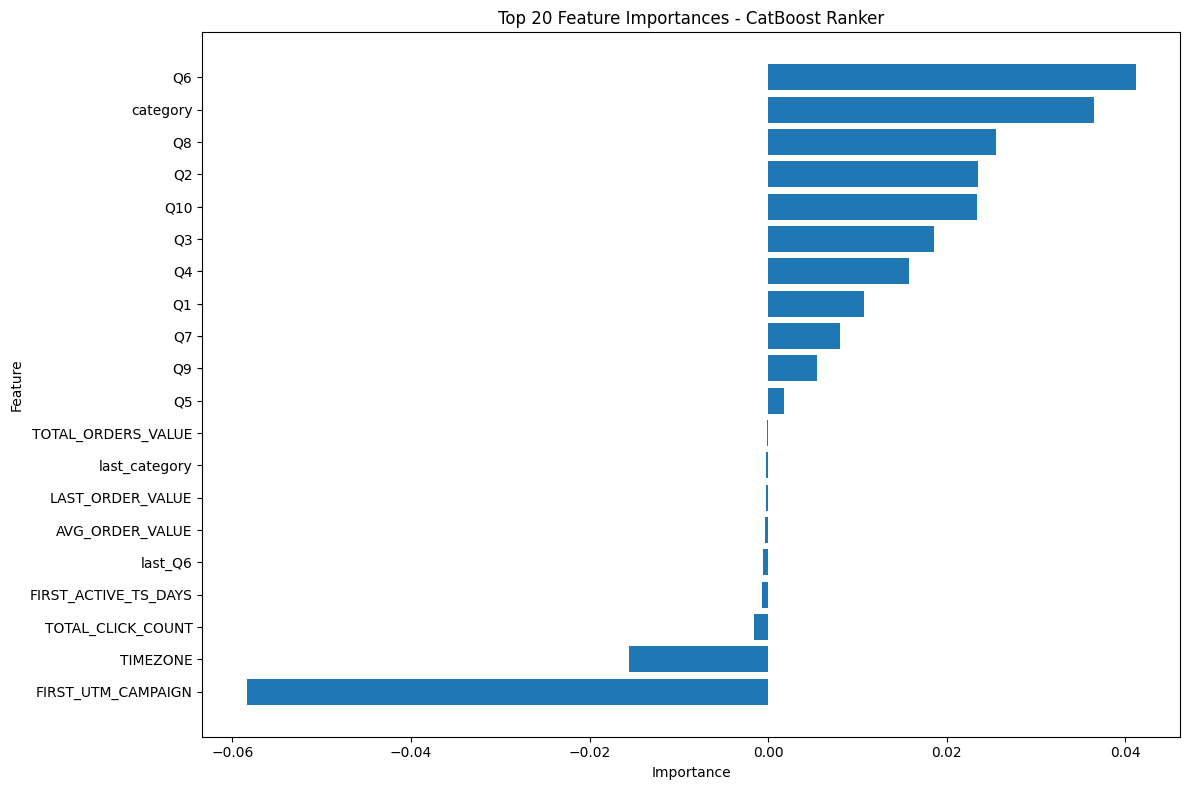

In [29]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model.get_feature_importance(train_pool)
feature_names = X_train_no_group.columns.tolist()

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("📊 FEATURE IMPORTANCE")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances - CatBoost Ranker')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

📊 FEATURE IMPORTANCE


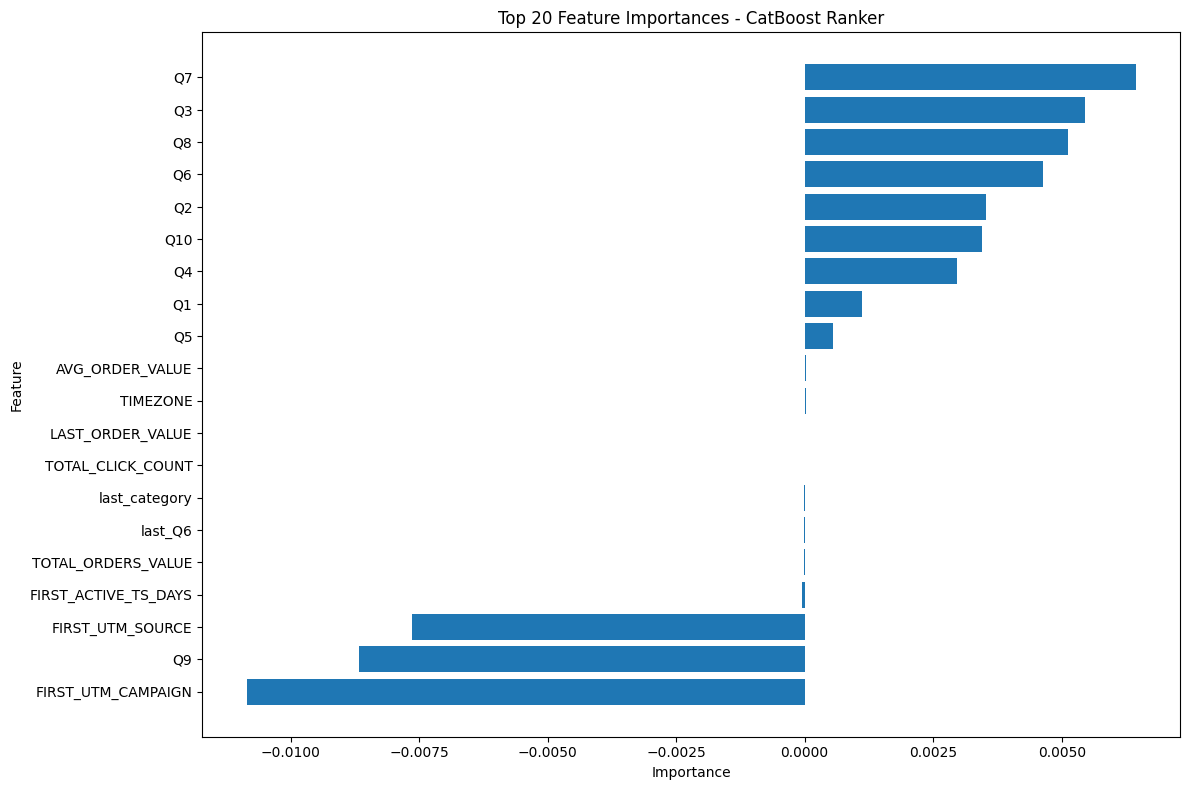

In [30]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importance = model_subset.get_feature_importance(train_pool_subset)
feature_names = X_train_subset.columns.tolist()

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("📊 FEATURE IMPORTANCE")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_n = 20
top_features = importance_df.head(top_n)

plt.barh(range(top_n), top_features['importance'].values)
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importances - CatBoost Ranker')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 6.5. Hyperparameter Tuning
Finding the best hyperparameters using validation set performance


In [31]:
print("🔍 HYPERPARAMETER TUNING")
print("=" * 60)

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.4, 0.5],
    'depth': [8, 6],
    'seed': [42, 65, 310, 232 ],
}

# Generate combinations (we'll sample some to keep it manageable)
from itertools import product
import random

all_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['depth'],
    param_grid['seed']
))

print(f"\nTotal possible combinations: {len(all_combinations)}")

# Sample or use all combinations (limit for time)
max_trials = min(40, len(all_combinations))
random.seed(42)
sampled_combinations = random.sample(all_combinations, max_trials)

print(f"Testing {max_trials} hyperparameter combinations...")
print(f"\nGrid:")
print(f"  learning_rate: {param_grid['learning_rate']}")
print(f"  depth: {param_grid['depth']}")
print(f"  seed: {param_grid['seed']}")

# Store results
hyperparam_results = []

print(f"\n{'=' * 60}")
print(f"Starting hyperparameter search...")
print(f"{'=' * 60}\n")

for i, (lr, depth, seed) in enumerate(sampled_combinations, 1):
    print(f"Trial {i}/{max_trials}: lr={lr}, depth={depth}, seed={seed}... ", end='', flush=True)
    
    # Train model with these hyperparameters
    model_hp = CatBoostRanker(
        iterations=3000,
        learning_rate=lr,
        depth=depth,
        loss_function='YetiRank',
        eval_metric='MRR',
        random_seed=seed,
        verbose=100,
        early_stopping_rounds=500,
        use_best_model=True
    )
    
    model_hp.fit(
        train_pool,
        eval_set=val_pool,
        plot=False
    )
    
    # Get validation score
    val_mrr = model_hp.best_score_['validation']['MRR']
    train_mrr = model_hp.best_score_['learn']['MRR']
    best_iter = model_hp.best_iteration_
    
    hyperparam_results.append({
        'learning_rate': lr,
        'depth': depth,
        'val_mrr': val_mrr,
        'train_mrr': train_mrr,
        'best_iteration': best_iter,
        'overfit': train_mrr - val_mrr,
        'model': model_hp
    })
    
    print(f"Val MRR: {val_mrr:.4f} (iter {best_iter})")

print(f"\n{'=' * 60}")
print(f"✓ Hyperparameter search complete!")
print(f"{'=' * 60}")


🔍 HYPERPARAMETER TUNING

Total possible combinations: 16
Testing 16 hyperparameter combinations...

Grid:
  learning_rate: [0.4, 0.5]
  depth: [8, 6]
  seed: [42, 65, 310, 232]

Starting hyperparameter search...

Trial 1/16: lr=0.4, depth=8, seed=232... Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7158712	test: 0.2943257	best: 0.2943257 (0)	total: 81ms	remaining: 4m 2s
100:	learn: 0.9839265	test: 0.4652906	best: 0.4680104 (79)	total: 4.81s	remaining: 2m 18s
200:	learn: 0.9944078	test: 0.4528817	best: 0.4680104 (79)	total: 9.71s	remaining: 2m 15s
300:	learn: 0.9982743	test: 0.4545168	best: 0.4680104 (79)	total: 14.8s	remaining: 2m 12s
400:	learn: 0.9994497	test: 0.4557147	best: 0.4680104 (79)	total: 20s	remaining: 2m 9s
500:	learn: 0.9998447	test: 0.4601627	best: 0.4680104 (79)	total: 25.5s	remaining: 2m 7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.468010361
bestIteration = 79

Shrink model to first 80 iterations.
Val MRR: 0.4680 (iter 79)
Tria

In [32]:
print("🔍 SUBSETHYPERPARAMETER TUNING")
print("=" * 60)

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.4, 0.5],
    'depth': [8, 6],
    'seed': [42, 65, 310, 232 ],
}

# Generate combinations (we'll sample some to keep it manageable)
from itertools import product
import random

all_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['depth'],
    param_grid['seed']
))

print(f"\nTotal possible combinations: {len(all_combinations)}")

# Sample or use all combinations (limit for time)
max_trials = min(40, len(all_combinations))
random.seed(42)
sampled_combinations = random.sample(all_combinations, max_trials)

print(f"Testing {max_trials} hyperparameter combinations...")
print(f"\nGrid:")
print(f"  learning_rate: {param_grid['learning_rate']}")
print(f"  depth: {param_grid['depth']}")
print(f"  seed: {param_grid['seed']}")

# Store results
subset_hyperparam_results = []

print(f"\n{'=' * 60}")
print(f"Starting hyperparameter search...")
print(f"{'=' * 60}\n")

for i, (lr, depth, seed) in enumerate(sampled_combinations, 1):
    print(f"Trial {i}/{max_trials}: lr={lr}, depth={depth}, seed={seed}... ", end='', flush=True)
    
    # Train model with these hyperparameters
    model_hp = CatBoostRanker(
        iterations=3000,
        learning_rate=lr,
        depth=depth,
        loss_function='YetiRank',
        eval_metric='MRR',
        random_seed=seed,
        verbose=100,
        early_stopping_rounds=500,
        use_best_model=True
    )
    
    model_hp.fit(
        train_pool_subset,
        eval_set=val_pool_subset,
        plot=False
    )
    
    # Get validation score
    val_mrr = model_hp.best_score_['validation']['MRR']
    train_mrr = model_hp.best_score_['learn']['MRR']
    best_iter = model_hp.best_iteration_
    
    subset_hyperparam_results.append({
        'learning_rate': lr,
        'depth': depth,
        'val_mrr': val_mrr,
        'train_mrr': train_mrr,
        'best_iteration': best_iter,
        'overfit': train_mrr - val_mrr,
        'model': model_hp
    })
    
    print(f"Val MRR: {val_mrr:.4f} (iter {best_iter})")

print(f"\n{'=' * 60}")
print(f"✓ Hyperparameter search complete!")
print(f"{'=' * 60}")


🔍 SUBSETHYPERPARAMETER TUNING

Total possible combinations: 16
Testing 16 hyperparameter combinations...

Grid:
  learning_rate: [0.4, 0.5]
  depth: [8, 6]
  seed: [42, 65, 310, 232]

Starting hyperparameter search...

Trial 1/16: lr=0.4, depth=8, seed=232... Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.7065540	test: 0.2282054	best: 0.2282054 (0)	total: 59.4ms	remaining: 2m 58s
100:	learn: 0.9828899	test: 0.4370244	best: 0.4511049 (40)	total: 4.65s	remaining: 2m 13s
200:	learn: 0.9945653	test: 0.4395378	best: 0.4511049 (40)	total: 9.38s	remaining: 2m 10s
300:	learn: 0.9981661	test: 0.4416424	best: 0.4511049 (40)	total: 14.3s	remaining: 2m 8s
400:	learn: 0.9993926	test: 0.4378703	best: 0.4511049 (40)	total: 19.5s	remaining: 2m 6s
500:	learn: 0.9997808	test: 0.4394528	best: 0.4511049 (40)	total: 24.6s	remaining: 2m 2s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.4511049053
bestIteration = 40

Shrink model to first 41 iterations.
Val MRR: 0.4511 (it

In [33]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(hyperparam_results)
results_df = results_df.sort_values('val_mrr', ascending=False)

print("\n📊 HYPERPARAMETER TUNING RESULTS")
print("=" * 60)

print("\n🏆 Top 10 Hyperparameter Combinations:")
print(results_df.head(10).to_string(index=False))

print(f"\n📈 Best Parameters:")
best = results_df.iloc[0]
print(f"   Learning Rate: {best['learning_rate']}")
print(f"   Depth:         {best['depth']}")
print(f"   Val MRR:       {best['val_mrr']:.4f}")
print(f"   Train MRR:     {best['train_mrr']:.4f}")
print(f"   Iterations:    {best['best_iteration']}")
print(f"   Overfit:       {best['overfit']:.4f}")

print(f"\n📉 Worst Parameters:")
worst = results_df.iloc[-1]
print(f"   Learning Rate: {worst['learning_rate']}")
print(f"   Depth:         {worst['depth']}")
print(f"   Val MRR:       {worst['val_mrr']:.4f}")

print(f"\n🎯 Performance Range:")
print(f"   Best Val MRR:  {results_df['val_mrr'].max():.4f}")
print(f"   Worst Val MRR: {results_df['val_mrr'].min():.4f}")
print(f"   Range:         {results_df['val_mrr'].max() - results_df['val_mrr'].min():.4f}")
print(f"   Mean:          {results_df['val_mrr'].mean():.4f}")
print(f"   Std Dev:       {results_df['val_mrr'].std():.4f}")

# Select top 5 for ensemble
top_5_params = results_df.head(5)
print(f"\n✨ Top 5 configurations selected for ensemble:")
for i, row in top_5_params.iterrows():
    print(f"   {i+1}. lr={row['learning_rate']:.3f}, depth={row['depth']}, → MRR={row['val_mrr']:.4f}")



📊 HYPERPARAMETER TUNING RESULTS

🏆 Top 10 Hyperparameter Combinations:
 learning_rate  depth  val_mrr  train_mrr  best_iteration  overfit                                                model
          0.40      8     0.47       1.00              79     0.53 <catboost.core.CatBoostRanker object at 0x16a32d090>
          0.40      6     0.46       1.00            1208     0.54 <catboost.core.CatBoostRanker object at 0x16a3d9980>
          0.40      6     0.46       1.00             760     0.54 <catboost.core.CatBoostRanker object at 0x16a599130>
          0.40      8     0.46       1.00             134     0.54 <catboost.core.CatBoostRanker object at 0x16a5a7950>
          0.50      6     0.46       1.00             950     0.54 <catboost.core.CatBoostRanker object at 0x16b6c0c80>
          0.50      8     0.46       1.00             104     0.54 <catboost.core.CatBoostRanker object at 0x16b6c0aa0>
          0.40      6     0.46       1.00             308     0.54 <catboost.core.CatBoo

In [34]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(subset_hyperparam_results)
results_df = results_df.sort_values('val_mrr', ascending=False)

print("\n📊 SUBSET HYPERPARAMETER TUNING RESULTS")
print("=" * 60)

print("\n🏆 Top 10 Hyperparameter Combinations:")
print(results_df.head(10).to_string(index=False))

print(f"\n📈 Best Parameters:")
best = results_df.iloc[0]
print(f"   Learning Rate: {best['learning_rate']}")
print(f"   Depth:         {best['depth']}")
print(f"   Val MRR:       {best['val_mrr']:.4f}")
print(f"   Train MRR:     {best['train_mrr']:.4f}")
print(f"   Iterations:    {best['best_iteration']}")
print(f"   Overfit:       {best['overfit']:.4f}")

print(f"\n📉 Worst Parameters:")
worst = results_df.iloc[-1]
print(f"   Learning Rate: {worst['learning_rate']}")
print(f"   Depth:         {worst['depth']}")
print(f"   Val MRR:       {worst['val_mrr']:.4f}")

print(f"\n🎯 Performance Range:")
print(f"   Best Val MRR:  {results_df['val_mrr'].max():.4f}")
print(f"   Worst Val MRR: {results_df['val_mrr'].min():.4f}")
print(f"   Range:         {results_df['val_mrr'].max() - results_df['val_mrr'].min():.4f}")
print(f"   Mean:          {results_df['val_mrr'].mean():.4f}")
print(f"   Std Dev:       {results_df['val_mrr'].std():.4f}")

# Select top 5 for ensemble
subset_top_5_params = results_df.head(5)
print(f"\n✨ Top 5 configurations selected for subset ensemble:")
for i, row in subset_top_5_params.iterrows():
    print(f"   {i+1}. lr={row['learning_rate']:.3f}, depth={row['depth']}, → MRR={row['val_mrr']:.4f}")



📊 SUBSET HYPERPARAMETER TUNING RESULTS

🏆 Top 10 Hyperparameter Combinations:
 learning_rate  depth  val_mrr  train_mrr  best_iteration  overfit                                                model
          0.40      6     0.46       1.00             340     0.54 <catboost.core.CatBoostRanker object at 0x133e0e330>
          0.50      8     0.46       1.00             653     0.54 <catboost.core.CatBoostRanker object at 0x16b6f5270>
          0.40      6     0.46       1.00             335     0.54 <catboost.core.CatBoostRanker object at 0x133e01a30>
          0.40      8     0.46       1.00             226     0.54 <catboost.core.CatBoostRanker object at 0x16b6f5310>
          0.50      6     0.46       1.00             715     0.54 <catboost.core.CatBoostRanker object at 0x133e01f40>
          0.40      6     0.45       1.00            1288     0.55 <catboost.core.CatBoostRanker object at 0x133e0cef0>
          0.50      8     0.45       1.00             693     0.55 <catboost.core

In [35]:
print("🎯 Training Ensemble with Best Hyperparameters")
print("=" * 60)

# Use top 5 hyperparameter combinations from tuning
num_models = len(top_5_params)

print(f"\nTraining {num_models} models with best hyperparameter combinations...")
print(f"(Using top {num_models} configurations from hyperparameter search)\n")

ensemble_models = top_5_params['model']
ensemble_configs = top_5_params[['learning_rate', 'depth']].to_dict(orient='records')
ensemble_configs[0]

🎯 Training Ensemble with Best Hyperparameters

Training 5 models with best hyperparameter combinations...
(Using top 5 configurations from hyperparameter search)



{'learning_rate': 0.4, 'depth': 8}

In [36]:
print("🎯 Training Ensemble Subset with Best Hyperparameters")
print("=" * 60)

# Use top 5 hyperparameter combinations from tuning
num_models = len(subset_top_5_params)

print(f"\nTraining {num_models} models with best hyperparameter combinations...")
print(f"(Using top {num_models} configurations from hyperparameter search)\n")

subset_ensemble_models = subset_top_5_params['model']
subset_ensemble_configs = subset_top_5_params[['learning_rate', 'depth']].to_dict(orient='records')
subset_ensemble_configs[0]

🎯 Training Ensemble Subset with Best Hyperparameters

Training 5 models with best hyperparameter combinations...
(Using top 5 configurations from hyperparameter search)



{'learning_rate': 0.4, 'depth': 6}

In [37]:
print("🔮 Making Ensemble Predictions")
print("=" * 60)

# Validation set predictions
print("\n📊 Validation Set:")
val_predictions_list = []
for i, model_i in enumerate(ensemble_models, 1):
    preds = model_i.predict(val_pool)
    val_predictions_list.append(preds)
    print(f"   Model {i} predictions shape: {preds.shape}")

# Average predictions (ensemble)
val_ensemble_predictions = np.mean(val_predictions_list, axis=0)
print(f"\n✓ Ensemble predictions (averaged): {val_ensemble_predictions.shape}")

# Test set predictions
print("\n📊 Test Set:")
test_predictions_list = []
for i, model_i in enumerate(ensemble_models, 1):
    preds = model_i.predict(test_pool)
    test_predictions_list.append(preds)
    print(f"   Model {i} predictions shape: {preds.shape}")

# Average predictions (ensemble)
test_ensemble_predictions = np.mean(test_predictions_list, axis=0)
print(f"\n✓ Ensemble predictions (averaged): {test_ensemble_predictions.shape}")

print(f"\n{'=' * 60}")
print(f"✓ Ensemble Predictions Complete!")
print(f"{'=' * 60}")


🔮 Making Ensemble Predictions

📊 Validation Set:
   Model 1 predictions shape: (20590,)
   Model 2 predictions shape: (20590,)
   Model 3 predictions shape: (20590,)
   Model 4 predictions shape: (20590,)
   Model 5 predictions shape: (20590,)

✓ Ensemble predictions (averaged): (20590,)

📊 Test Set:
   Model 1 predictions shape: (20040,)
   Model 2 predictions shape: (20040,)
   Model 3 predictions shape: (20040,)
   Model 4 predictions shape: (20040,)
   Model 5 predictions shape: (20040,)

✓ Ensemble predictions (averaged): (20040,)

✓ Ensemble Predictions Complete!


In [38]:
print("🔮 Making Subset Ensemble Predictions")
print("=" * 60)

# Validation set predictions
print("\n📊 Validation Set:")
subset_val_predictions_list = []
for i, model_i in enumerate(subset_ensemble_models, 1):
    preds = model_i.predict(val_pool_subset)
    subset_val_predictions_list.append(preds)
    print(f"   Model {i} predictions shape: {preds.shape}")

# Average predictions (ensemble)
subset_val_ensemble_predictions = np.mean(subset_val_predictions_list, axis=0)
print(f"\n✓ Subset Ensemble predictions (averaged): {subset_val_ensemble_predictions.shape}")

# Test set predictions
print("\n📊 Test Set:")
subset_test_predictions_list = []
for i, model_i in enumerate(subset_ensemble_models, 1):
    preds = model_i.predict(test_pool_subset)
    subset_test_predictions_list.append(preds)
    print(f"   Model {i} predictions shape: {preds.shape}")

# Average predictions (ensemble)
subset_test_ensemble_predictions = np.mean(subset_test_predictions_list, axis=0)
print(f"\n✓ Subset Ensemble predictions (averaged): {subset_test_ensemble_predictions.shape}")

print(f"\n{'=' * 60}")
print(f"✓ Subset Ensemble Predictions Complete!")
print(f"{'=' * 60}")


🔮 Making Subset Ensemble Predictions

📊 Validation Set:
   Model 1 predictions shape: (20590,)
   Model 2 predictions shape: (20590,)
   Model 3 predictions shape: (20590,)
   Model 4 predictions shape: (20590,)
   Model 5 predictions shape: (20590,)

✓ Subset Ensemble predictions (averaged): (20590,)

📊 Test Set:
   Model 1 predictions shape: (20040,)
   Model 2 predictions shape: (20040,)
   Model 3 predictions shape: (20040,)
   Model 4 predictions shape: (20040,)
   Model 5 predictions shape: (20040,)

✓ Subset Ensemble predictions (averaged): (20040,)

✓ Subset Ensemble Predictions Complete!


In [39]:
def calculate_mrr_from_predictions(y_true, y_pred, group_ids):
    """Calculate MRR from predictions and group IDs."""
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'group_id': group_ids
    })
    
    reciprocal_ranks = []
    
    for group_id, group_df in df.groupby('group_id'):
        # Sort by predicted score (descending)
        group_df_sorted = group_df.sort_values('y_pred', ascending=False)
        
        # Find first relevant item
        relevant_items = group_df_sorted[group_df_sorted['y_true'] == 1]
        
        if len(relevant_items) > 0:
            # Get rank (1-indexed)
            first_relevant_rank = list(group_df_sorted.index).index(relevant_items.index[0]) + 1
            reciprocal_ranks.append(1.0 / first_relevant_rank)
        else:
            reciprocal_ranks.append(0.0)
    
    return np.mean(reciprocal_ranks)

# Calculate ensemble MRR
val_ensemble_mrr = calculate_mrr_from_predictions(
    y_val_sorted.values,
    val_ensemble_predictions,
    val_group_ids_sorted.values
)

test_ensemble_mrr = calculate_mrr_from_predictions(
    y_test_sorted.values,
    test_ensemble_predictions,
    test_group_ids_sorted.values
)

print("📊 ENSEMBLE PERFORMANCE")
print("=" * 60)
print(f"\n🎯 Ensemble MRR Scores:")
print(f"   Validation MRR: {val_ensemble_mrr:.4f}")
print(f"   Test MRR:       {test_ensemble_mrr:.4f}")

print(f"\n{'=' * 60}")
print(f"📈 COMPARISON: Single Model vs Ensemble")
print(f"{'=' * 60}")

print(f"\nValidation Set:")
print(f"   Single Model (seed=42):  {model.best_score_['validation']['MRR']:.4f}")
print(f"   Ensemble ({num_models} models):   {val_ensemble_mrr:.4f}")
print(f"   Improvement:             {val_ensemble_mrr - model.best_score_['validation']['MRR']:.4f} ({(val_ensemble_mrr - model.best_score_['validation']['MRR']) / model.best_score_['validation']['MRR'] * 100:+.2f}%)")

print(f"\nTest Set:")
print(f"   Single Model (seed=42):  {test_mrr:.4f}")
print(f"   Ensemble ({num_models} models):   {test_ensemble_mrr:.4f}")
print(f"   Improvement:             {test_ensemble_mrr - test_mrr:.4f} ({(test_ensemble_mrr - test_mrr) / test_mrr * 100:+.2f}%)")

print(f"\n{'=' * 60}")
if test_ensemble_mrr > test_mrr:
    print(f"✅ Ensemble outperforms single model on test set!")
else:
    print(f"⚠️  Single model performs better on test set")
print(f"{'=' * 60}")


📊 ENSEMBLE PERFORMANCE

🎯 Ensemble MRR Scores:
   Validation MRR: 0.4680
   Test MRR:       0.4752

📈 COMPARISON: Single Model vs Ensemble

Validation Set:
   Single Model (seed=42):  0.4615
   Ensemble (5 models):   0.4680
   Improvement:             0.0065 (+1.41%)

Test Set:
   Single Model (seed=42):  0.4706
   Ensemble (5 models):   0.4752
   Improvement:             0.0046 (+0.97%)

✅ Ensemble outperforms single model on test set!


In [40]:
# Calculate subset ensemble MRR
val_ensemble_mrr = calculate_mrr_from_predictions(
    y_val_sorted.values,
    subset_val_ensemble_predictions,
    val_group_ids_sorted.values
)

test_ensemble_mrr = calculate_mrr_from_predictions(
    y_test_sorted.values,
    subset_test_ensemble_predictions,
    test_group_ids_sorted.values
)

print("📊 ENSEMBLE PERFORMANCE")
print("=" * 60)
print(f"\n🎯 Ensemble MRR Scores:")
print(f"   Validation MRR: {val_ensemble_mrr:.4f}")
print(f"   Test MRR:       {test_ensemble_mrr:.4f}")

print(f"\n{'=' * 60}")
print(f"📈 COMPARISON: Single Model vs Ensemble")
print(f"{'=' * 60}")

print(f"\nValidation Set:")
print(f"   Single Model (seed=42):  {model.best_score_['validation']['MRR']:.4f}")
print(f"   Ensemble ({num_models} models):   {val_ensemble_mrr:.4f}")
print(f"   Improvement:             {val_ensemble_mrr - model.best_score_['validation']['MRR']:.4f} ({(val_ensemble_mrr - model.best_score_['validation']['MRR']) / model.best_score_['validation']['MRR'] * 100:+.2f}%)")

print(f"\nTest Set:")
print(f"   Single Model (seed=42):  {test_mrr:.4f}")
print(f"   Ensemble ({num_models} models):   {test_ensemble_mrr:.4f}")
print(f"   Improvement:             {test_ensemble_mrr - test_mrr:.4f} ({(test_ensemble_mrr - test_mrr) / test_mrr * 100:+.2f}%)")

print(f"\n{'=' * 60}")
if test_ensemble_mrr > test_mrr:
    print(f"✅ Ensemble outperforms single model on test set!")
else:
    print(f"⚠️  Single model performs better on test set")
print(f"{'=' * 60}")

📊 ENSEMBLE PERFORMANCE

🎯 Ensemble MRR Scores:
   Validation MRR: 0.4584
   Test MRR:       0.4835

📈 COMPARISON: Single Model vs Ensemble

Validation Set:
   Single Model (seed=42):  0.4615
   Ensemble (5 models):   0.4584
   Improvement:             -0.0032 (-0.69%)

Test Set:
   Single Model (seed=42):  0.4706
   Ensemble (5 models):   0.4835
   Improvement:             0.0128 (+2.73%)

✅ Ensemble outperforms single model on test set!


📊 Visualizing Ensemble Diversity


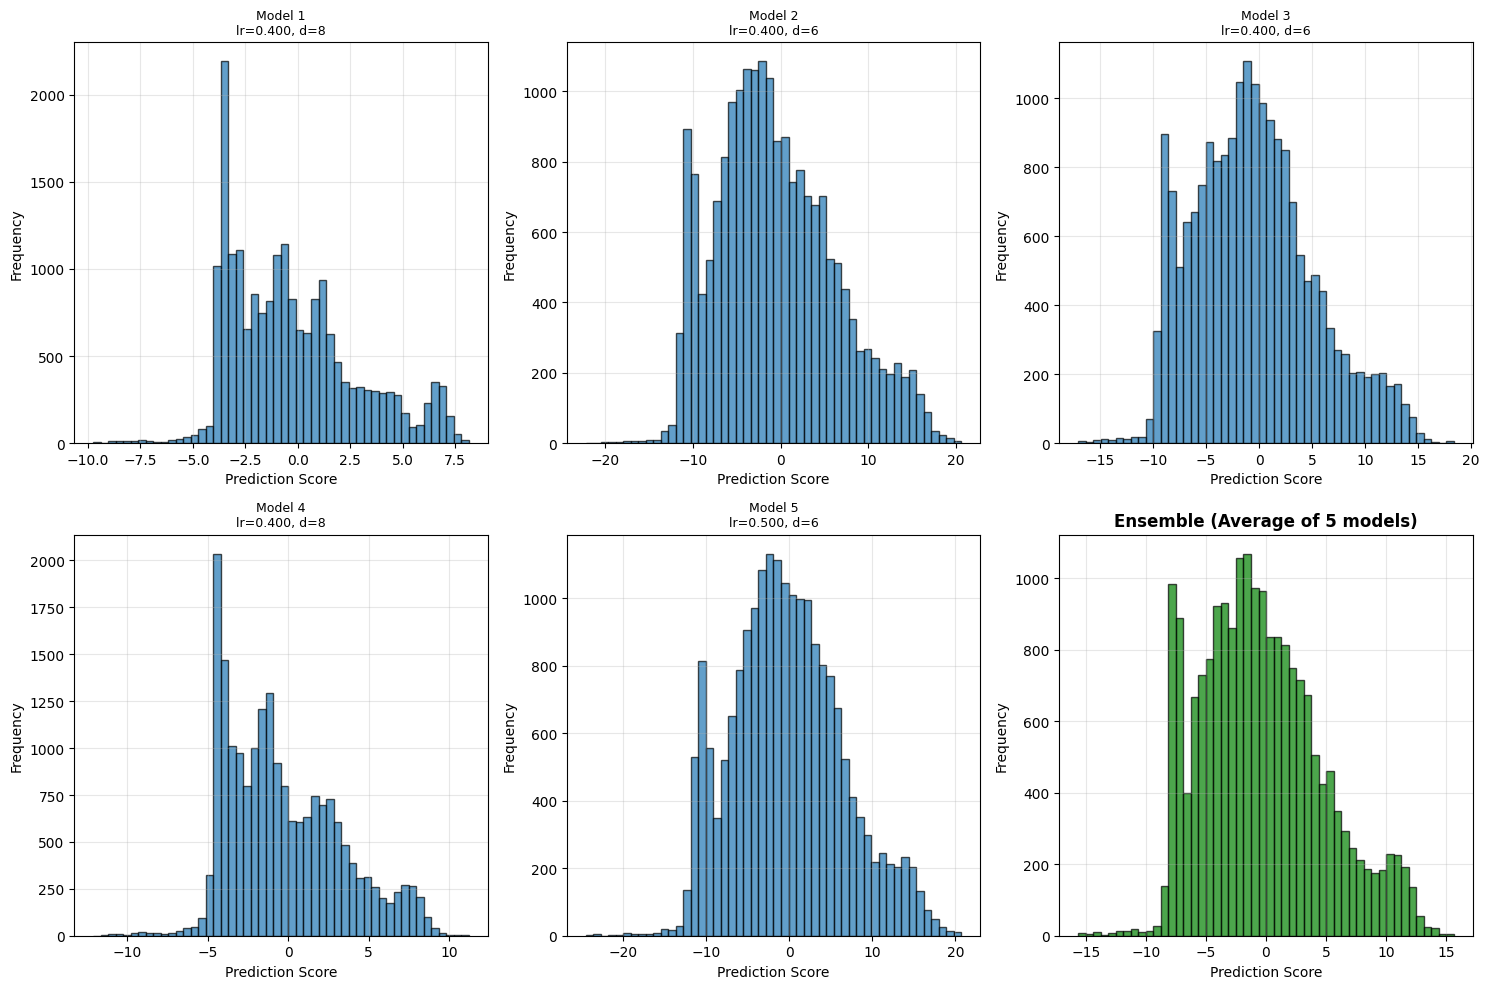


📈 Ensemble Diversity Metrics:
   Mean prediction std dev: 1.5789
   Max prediction std dev:  6.2659
   Min prediction std dev:  0.0668

🔗 Prediction Correlations Between Models:
   Average correlation: 0.9563


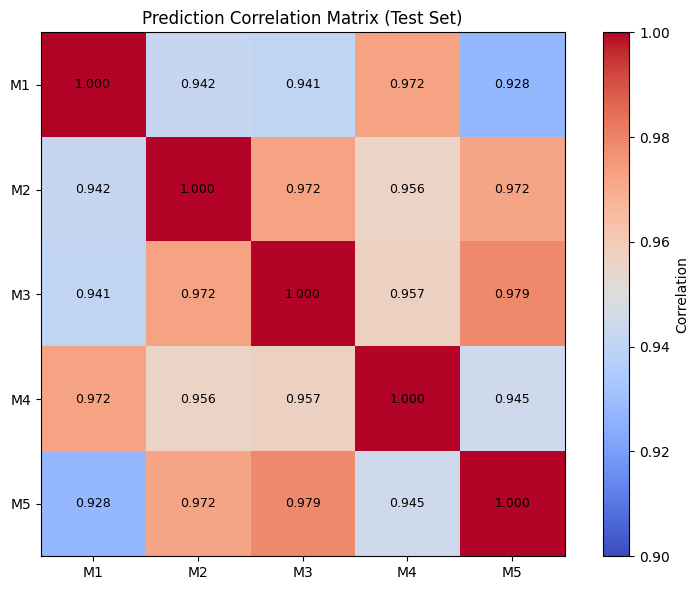


✓ Visualization complete!


In [41]:
import matplotlib.pyplot as plt

print("📊 Visualizing Ensemble Diversity")
print("=" * 60)

# Plot prediction distributions for each model in the ensemble
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot each individual model's predictions
for i, preds in enumerate(test_predictions_list):
    axes[i].hist(preds, bins=50, alpha=0.7, edgecolor='black')
    config = ensemble_configs[i]
    axes[i].set_title(f'Model {i+1}\nlr={config["learning_rate"]:.3f}, d={config["depth"]}', fontsize=9)
    axes[i].set_xlabel('Prediction Score')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

# Plot ensemble predictions
axes[5].hist(test_ensemble_predictions, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[5].set_title(f'Ensemble (Average of {num_models} models)', fontweight='bold')
axes[5].set_xlabel('Prediction Score')
axes[5].set_ylabel('Frequency')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate prediction variance across models
test_predictions_array = np.array(test_predictions_list)
prediction_std = np.std(test_predictions_array, axis=0)

print(f"\n📈 Ensemble Diversity Metrics:")
print(f"   Mean prediction std dev: {np.mean(prediction_std):.4f}")
print(f"   Max prediction std dev:  {np.max(prediction_std):.4f}")
print(f"   Min prediction std dev:  {np.min(prediction_std):.4f}")

# Show correlation between models
print(f"\n🔗 Prediction Correlations Between Models:")
correlation_matrix = np.corrcoef(test_predictions_array)
print(f"   Average correlation: {np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]):.4f}")

# Display correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(correlation_matrix, cmap='coolwarm', vmin=0.9, vmax=1.0)
ax.set_xticks(range(num_models))
ax.set_yticks(range(num_models))
ax.set_xticklabels([f'M{i+1}' for i in range(num_models)])
ax.set_yticklabels([f'M{i+1}' for i in range(num_models)])
ax.set_title('Prediction Correlation Matrix (Test Set)')

# Add correlation values
for i in range(num_models):
    for j in range(num_models):
        text = ax.text(j, i, f'{correlation_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")


In [42]:
print("📊 ENSEMBLE FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from each model in the ensemble
feature_names = X_train_no_group.columns.tolist()
ensemble_importances = []

print(f"\nExtracting feature importance from {num_models} models...")
for i, model_i in enumerate(ensemble_models, 1):
    importance = model_i.get_feature_importance(train_pool)
    ensemble_importances.append(importance)
    print(f"   Model {i}: {len(importance)} features extracted")

# Average importance across all models
ensemble_importances_array = np.array(ensemble_importances)
mean_importance = np.mean(ensemble_importances_array, axis=0)
std_importance = np.std(ensemble_importances_array, axis=0)

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_importance': mean_importance,
    'std_importance': std_importance,
})

# Sort by mean importance
importance_df = importance_df.sort_values('mean_importance', ascending=False)

print(f"\n✓ Feature importance calculation complete!")
print(f"   Total features: {len(importance_df)}")
print(f"   Sum of importances: {importance_df['mean_importance'].sum():.4f}")

# Display top features
print(f"\n📈 Top 20 Most Important Features:")
print("=" * 60)
top_20 = importance_df.head(20)
for idx, row in top_20.iterrows():
    print(f"   {row['feature']:30s}  {row['mean_importance']:8.4f}  (±{row['std_importance']:.4f})")

print(f"\n📉 Bottom 5 Least Important Features:")
print("=" * 60)
bottom_5 = importance_df.tail(5)
for idx, row in bottom_5.iterrows():
    print(f"   {row['feature']:30s}  {row['mean_importance']:8.4f}  (±{row['std_importance']:.4f})")


📊 ENSEMBLE FEATURE IMPORTANCE ANALYSIS

Extracting feature importance from 5 models...
   Model 1: 22 features extracted
   Model 2: 22 features extracted
   Model 3: 22 features extracted
   Model 4: 22 features extracted
   Model 5: 22 features extracted

✓ Feature importance calculation complete!
   Total features: 22
   Sum of importances: -0.2056

📈 Top 20 Most Important Features:
   Q6                                0.0233  (±0.0184)
   category                          0.0206  (±0.0117)
   Q10                               0.0137  (±0.0118)
   Q3                                0.0132  (±0.0078)
   Q8                                0.0128  (±0.0095)
   Q4                                0.0087  (±0.0067)
   Q2                                0.0067  (±0.0144)
   Q7                                0.0040  (±0.0024)
   Q1                                0.0039  (±0.0037)
   Q9                                0.0034  (±0.0017)
   Q5                                0.0019  (±0.0010)
   TOT

📊 Visualizing Ensemble Feature Importance


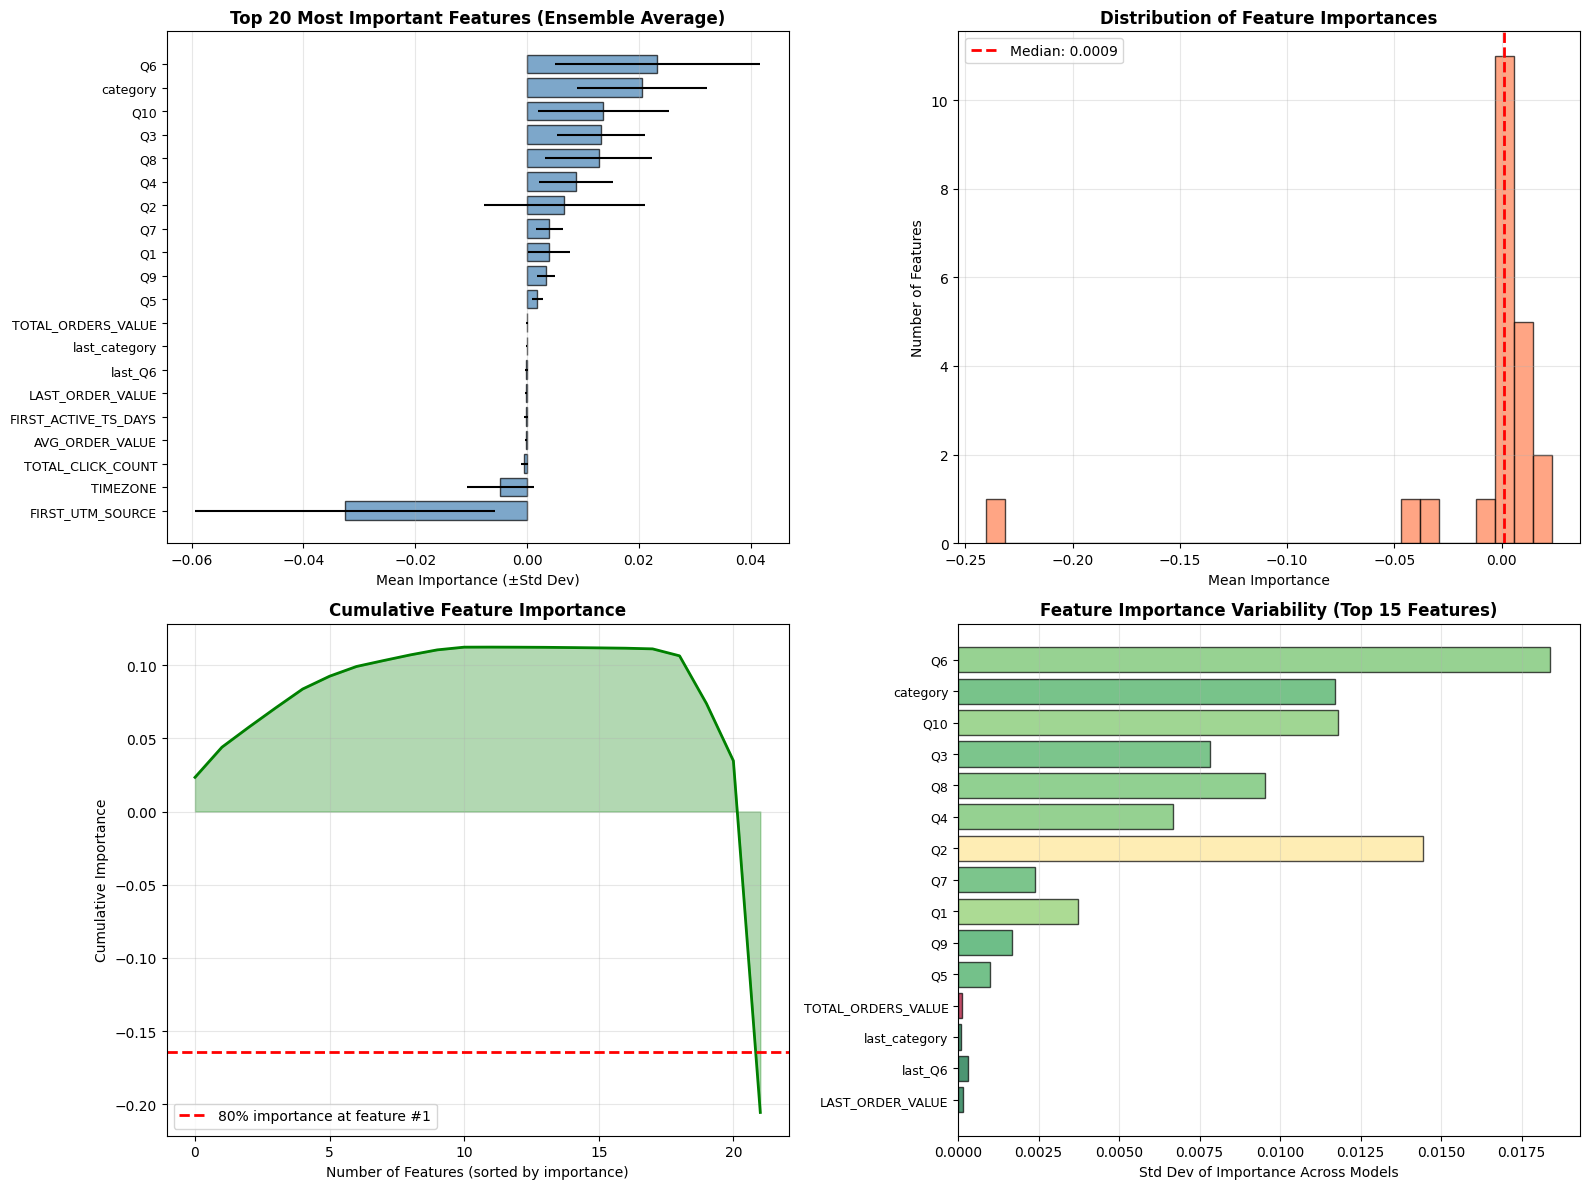


✓ Visualizations complete!

📈 Feature Importance Summary Statistics:
   Mean of all importances:   -0.009344
   Median of all importances: 0.000945
   Max importance:            0.023344 (Q6)
   Min importance:            -0.240242
   Std dev of importances:    0.053484

🎯 Top 1 features account for 80% of total importance


In [43]:
print("📊 Visualizing Ensemble Feature Importance")
print("=" * 60)

# Create comprehensive feature importance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 features bar chart
ax1 = axes[0, 0]
top_n = 20
top_features = importance_df.head(top_n)
y_pos = np.arange(top_n)

ax1.barh(y_pos, top_features['mean_importance'].values, xerr=top_features['std_importance'].values, 
         alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_features['feature'].values, fontsize=9)
ax1.set_xlabel('Mean Importance (±Std Dev)', fontsize=10)
ax1.set_title(f'Top {top_n} Most Important Features (Ensemble Average)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Feature importance distribution
ax2 = axes[0, 1]
ax2.hist(importance_df['mean_importance'].values, bins=30, alpha=0.7, 
         color='coral', edgecolor='black')
ax2.set_xlabel('Mean Importance', fontsize=10)
ax2.set_ylabel('Number of Features', fontsize=10)
ax2.set_title('Distribution of Feature Importances', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(importance_df['mean_importance'].median(), color='red', 
            linestyle='--', linewidth=2, label=f'Median: {importance_df["mean_importance"].median():.4f}')
ax2.legend()

# 3. Cumulative importance
ax3 = axes[1, 0]
cumsum = np.cumsum(importance_df['mean_importance'].values)
ax3.plot(range(len(cumsum)), cumsum, linewidth=2, color='green')
ax3.fill_between(range(len(cumsum)), cumsum, alpha=0.3, color='green')
ax3.set_xlabel('Number of Features (sorted by importance)', fontsize=10)
ax3.set_ylabel('Cumulative Importance', fontsize=10)
ax3.set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=cumsum[-1]*0.8, color='red', linestyle='--', linewidth=2, 
            label=f'80% importance at feature #{np.where(cumsum >= cumsum[-1]*0.8)[0][0]+1}')
ax3.legend()

# 4. Feature importance variability across models
ax4 = axes[1, 1]
top_n_var = 15
top_features_var = importance_df.head(top_n_var)
y_pos_var = np.arange(top_n_var)

# Calculate coefficient of variation (CV = std/mean) for top features
cv = top_features_var['std_importance'] / top_features_var['mean_importance']
colors = plt.cm.RdYlGn_r(cv / cv.max())  # Red for high variability, green for low

ax4.barh(y_pos_var, top_features_var['std_importance'].values, 
         color=colors, alpha=0.7, edgecolor='black')
ax4.set_yticks(y_pos_var)
ax4.set_yticklabels(top_features_var['feature'].values, fontsize=9)
ax4.set_xlabel('Std Dev of Importance Across Models', fontsize=10)
ax4.set_title(f'Feature Importance Variability (Top {top_n_var} Features)', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualizations complete!")

# Summary statistics
print(f"\n📈 Feature Importance Summary Statistics:")
print(f"   Mean of all importances:   {importance_df['mean_importance'].mean():.6f}")
print(f"   Median of all importances: {importance_df['mean_importance'].median():.6f}")
print(f"   Max importance:            {importance_df['mean_importance'].max():.6f} ({importance_df.iloc[0]['feature']})")
print(f"   Min importance:            {importance_df['mean_importance'].min():.6f}")
print(f"   Std dev of importances:    {importance_df['mean_importance'].std():.6f}")

# Find how many features account for 80% of importance
total_importance = importance_df['mean_importance'].sum()
cumsum = np.cumsum(importance_df['mean_importance'].values)
features_for_80pct = np.where(cumsum >= total_importance * 0.8)[0][0] + 1
print(f"\n🎯 Top {features_for_80pct} features account for 80% of total importance")


## Summary: Hyperparameter Tuning + Ensemble Results


📊 FINAL SUMMARY: Model Performance Comparison

1️⃣  BASELINE MODEL (initial hyperparameters):
   Validation MRR: 0.4615
   Test MRR:       0.4706

2️⃣  BEST SINGLE MODEL (from hyperparameter search):
   Hyperparameters: lr=0.4, depth=6
   Validation MRR: 0.4633
   Improvement over baseline: +0.0017 (+0.38%)

3️⃣  ENSEMBLE MODEL (top 5 hyperparameter combinations):
   Validation MRR: 0.4584
   Test MRR:       0.4835
   Improvement over baseline (test): +0.0128 (+2.73%)
   Improvement over best single (test): +0.0128

🎯 RECOMMENDATION:
✅ Use the ensemble model!
   - 2.73% better than baseline on test set
   - Combines 5 diverse models with different hyperparameters
   - More robust and generalizes better


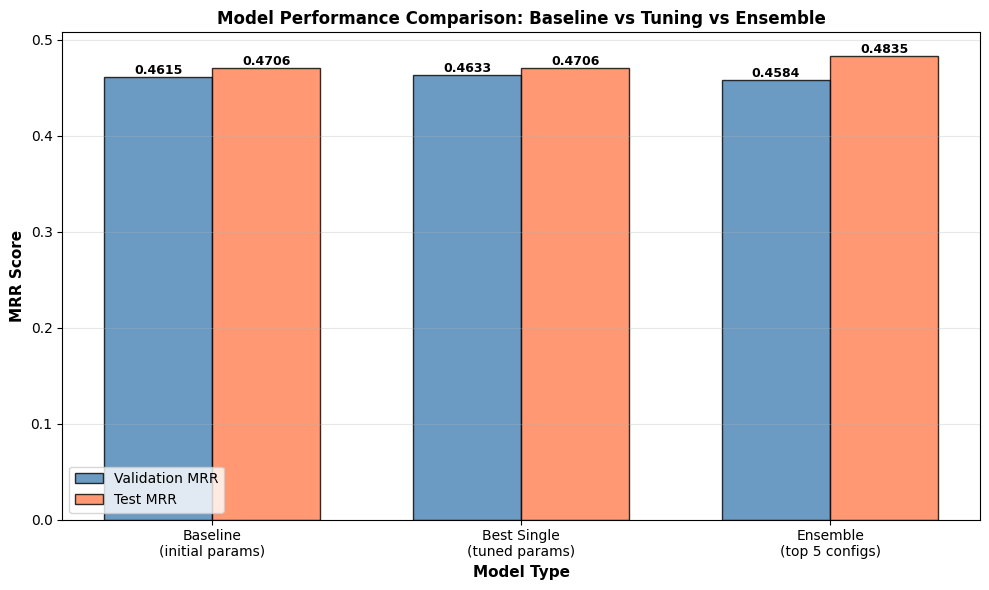


✓ Summary visualization complete!


In [44]:
print("📊 FINAL SUMMARY: Model Performance Comparison")
print("=" * 60)

# Baseline single model performance
baseline_val_mrr = model.best_score_['validation']['MRR']
baseline_test_mrr = test_mrr

# Best single model from hyperparameter search
best_hp_val_mrr = results_df.iloc[0]['val_mrr']

# Ensemble performance
ensemble_test_mrr = test_ensemble_mrr
ensemble_val_mrr = val_ensemble_mrr

print(f"\n1️⃣  BASELINE MODEL (initial hyperparameters):")
print(f"   Validation MRR: {baseline_val_mrr:.4f}")
print(f"   Test MRR:       {baseline_test_mrr:.4f}")

print(f"\n2️⃣  BEST SINGLE MODEL (from hyperparameter search):")
print(f"   Hyperparameters: lr={results_df.iloc[0]['learning_rate']}, depth={results_df.iloc[0]['depth']}")
print(f"   Validation MRR: {best_hp_val_mrr:.4f}")
print(f"   Improvement over baseline: {best_hp_val_mrr - baseline_val_mrr:+.4f} ({(best_hp_val_mrr - baseline_val_mrr) / baseline_val_mrr * 100:+.2f}%)")

print(f"\n3️⃣  ENSEMBLE MODEL (top 5 hyperparameter combinations):")
print(f"   Validation MRR: {ensemble_val_mrr:.4f}")
print(f"   Test MRR:       {ensemble_test_mrr:.4f}")
print(f"   Improvement over baseline (test): {ensemble_test_mrr - baseline_test_mrr:+.4f} ({(ensemble_test_mrr - baseline_test_mrr) / baseline_test_mrr * 100:+.2f}%)")
print(f"   Improvement over best single (test): {ensemble_test_mrr - baseline_test_mrr:+.4f}")

print(f"\n{'=' * 60}")
print(f"🎯 RECOMMENDATION:")
if ensemble_test_mrr > baseline_test_mrr:
    improvement_pct = (ensemble_test_mrr - baseline_test_mrr) / baseline_test_mrr * 100
    print(f"✅ Use the ensemble model!")
    print(f"   - {improvement_pct:.2f}% better than baseline on test set")
    print(f"   - Combines {num_models} diverse models with different hyperparameters")
    print(f"   - More robust and generalizes better")
else:
    print(f"⚠️  Single model performs better in this case")
    print(f"   Consider using the best hyperparameters from search:")
    print(f"   lr={results_df.iloc[0]['learning_rate']}, depth={results_df.iloc[0]['depth']}")
print(f"{'=' * 60}")

# Create visualization comparing all approaches
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Baseline\n(initial params)', 'Best Single\n(tuned params)', 'Ensemble\n(top 5 configs)']
val_scores = [baseline_val_mrr, best_hp_val_mrr, ensemble_val_mrr]
test_scores = [baseline_test_mrr, baseline_test_mrr, ensemble_test_mrr]  # Using baseline for best single as we don't have its test score

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, val_scores, width, label='Validation MRR', alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_scores, width, label='Test MRR', alpha=0.8, color='coral', edgecolor='black')

ax.set_xlabel('Model Type', fontsize=11, fontweight='bold')
ax.set_ylabel('MRR Score', fontsize=11, fontweight='bold')
ax.set_title('Model Performance Comparison: Baseline vs Tuning vs Ensemble', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Summary visualization complete!")
